In [27]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram, welch
import pywt
from scipy.signal import coherence, csd

In [37]:
class Portfolio:
    def __init__(self, filepath, name, columns_to_drop):
        self.name = name
        self.data = pd.read_csv(filepath, parse_dates=['Data'])
        self.preprocess(columns_to_drop)

    def preprocess(self, columns_to_drop):
        self.data.drop(columns=columns_to_drop, inplace=True)
        self.data['Return'] = np.log(self.data["Zamkniecie"]) - np.log(self.data["Zamkniecie"].shift(1))
        self.data = self.data.iloc[1:]

    def plot_closing_values(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.data["Data"], self.data["Zamkniecie"])
        plt.title(f'{self.name} - Wartości zamknięcia w czasie')
        plt.xticks(rotation=30, ha='right')
        plt.xlabel('Data')
        plt.ylabel('Wartość zamknięcia')
        save_path = os.path.join('wykresy', f'{self.name}_zamkniecie.png')
        plt.savefig(save_path)
        plt.show()

    def plot_return_rates(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.data['Return'], label=f'{self.name} Stopy zwrotu')
        plt.title(f'{self.name} Logarytmiczne stopy zwrotu')
        plt.xlabel('Dzień')
        plt.ylabel('Wartość stopy zwrotu')
        plt.legend()
        save_path = os.path.join('wykresy', f'{self.name}_stopy.png')
        plt.savefig(save_path)
        plt.show()

    def test_stationarity(self):
        # ADF test
        result_adf = adfuller(self.data['Return'].dropna())
        adf_statistic = result_adf[0]
        p_value_adf = result_adf[1]
        critical_values_adf = result_adf[4]
        
        # KPSS test
        result_kpss = kpss(self.data['Return'].dropna(), regression='c')
        kpss_statistic = result_kpss[0]
        p_value_kpss = result_kpss[1]
        critical_values_kpss = result_kpss[3]

        # Print results
        print(f"\nResults for {self.name}:")
        print("ADF Statistic:", adf_statistic)
        print("ADF p-value:", p_value_adf)
        print("ADF Critical Values:", critical_values_adf)
        
        if p_value_adf <= 0.05:
            print("ADF: Reject the null hypothesis. The data is likely stationary.")
        else:
            print("ADF: Fail to reject the null hypothesis. The data is likely non-stationary.")
            
        print("\nKPSS Statistic:", kpss_statistic)
        print("KPSS p-value:", p_value_kpss)
        print("KPSS Critical Values:", critical_values_kpss)
        
        if p_value_kpss <= 0.05:
            print("KPSS: Reject the null hypothesis. The data is likely non-stationary.")
        else:
            print("KPSS: Fail to reject the null hypothesis. The data is likely stationary.")
            

    def plot_autocorrelation(self, lags=90):
        """Plot the autocorrelation for the portfolio's returns."""
        data_ = self.data[['Data', 'Return']]
        data_.set_index('Data', inplace=True)
        
        plt.figure(figsize=(10, 6))
        plot_acf(data_, lags=lags)
        plt.title(f'{self.name} - Autokorelacja')
        plt.xlabel('Opóźnienia')
        plt.ylabel('Autokorelacja')
        
        save_path = os.path.join('wykresy', f'{self.name}_autokorelacja.png')
        plt.savefig(save_path)
        plt.show()

    def test_normality(self):
        """Test the normality of the portfolio's returns."""
        shapiro = stats.shapiro(self.data["Return"])
        anderson = stats.anderson(self.data["Return"])
        jarque_bera = stats.jarque_bera(self.data["Return"])
        
        print(f"Results for {self.name}:\n")
        print(f"Shapiro-Wilk: {shapiro}\n")
        print(f"Anderson-Darling: {anderson}\n")
        print(f"Jarque-Bera: {jarque_bera}\n")
        print("-" * 40)

    def weekday_effect(self):
        self.data["Week Day"] = self.data['Data'].dt.day_name()
        self.weekday_effect = self.data.groupby(['Week Day']).mean()['Zamkniecie']

    def anova(self):
        df = self.data[["Zamkniecie", "Week Day"]].copy()
        df.rename(columns={"Zamkniecie": "Close", "Week Day": "Week_Day"}, inplace=True)
        
        model = ols('Close ~ C(Week_Day)', data=df).fit()

        self.anova_result = sm.stats.anova_lm(model, typ=2)

    def weekday_boxplots(self):
        sns.boxplot(data=self.data, x='Week Day', y='Zamkniecie', 
                    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
        plt.xticks([0, 1, 2, 3, 4], ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek'])
        plt.title(f'Efekt dnia tygodnia dla portfela {self.name}')
        plt.xlabel('Dzień tygodnia')
        save_path = os.path.join('wykresy', f'{self.name}_dzien_tygodnia.png')
        plt.savefig(save_path)
        plt.show()

    def fast_fourier_transform(self):
        # Calculate delta
        self.data['delta'] = self.data['Return'].diff()
        self.data.fillna(0, inplace=True)
        
        # Apply FFT
        sp = np.fft.fft(self.data['delta'].values)
        self.data['theta'] = np.arctan(sp.imag/sp.real)
        numValues = len(self.data)
        numValuesHalf = numValues / 2
        self.data['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2) / numValuesHalf
        self.data['freq'] = np.fft.fftfreq(sp.size, d=1)
        
        # Plot
        data_positive_freq = self.data[self.data['freq'] >= 0]
        plt.figure(figsize=(15, 5))
        plt.plot(data_positive_freq['freq'], data_positive_freq['amplitude'].values, '.')
        plt.ylabel('Amplituda', fontsize=12)
        plt.xlabel('Częstość', fontsize=12)
        plt.title(f'Zakres Częstotliwości dla Portfela {self.name}', fontsize=18)
        plt.grid()
        save_path = os.path.join('wykresy', f'{self.name}_FFT.png')
        plt.savefig(save_path)
        plt.show()
        
        # Dominant frequencies
        meanAmp = self.data['amplitude'].mean()
        stdAmp = self.data['amplitude'].std()
        dominantAmpCheck = self.data['amplitude'] > (3*stdAmp + meanAmp) 
        positiveFreqCheck = self.data['freq'] > 0
        dominantAmp = self.data[dominantAmpCheck & positiveFreqCheck]['amplitude']
        dominantFreq = self.data[dominantAmpCheck & positiveFreqCheck]['freq']
        plt.figure(figsize=(15, 5))
        plt.plot(dominantFreq, dominantAmp, 'o')
        plt.ylabel('Amplituda', fontsize=12)
        plt.xlabel('Częstość', fontsize=12)
        plt.title(f'Zakres Częstotliwości dla Portfela {self.name} \n(Dominujące i dodatnie)', fontsize=18)
        plt.grid()
        save_path = os.path.join('wykresy', f'{self.name}_FFT_domin.png')
        plt.savefig(save_path)
        plt.show()

    def decompose(self):
        decomposition = seasonal_decompose(self.data['Return'], model='additive', period=252)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(4, 1, 1)
        plt.plot(decomposition.trend, color='blue')
        plt.title(f'{self.name} - Trend')
        
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.seasonal, color='orange')
        plt.title(f'{self.name} - Sezonowość')
        
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.resid, color='green')
        plt.title(f'{self.name} - Reszty')
        
        plt.subplot(4, 1, 4)
        plt.plot(self.data['Return'], color='black')
        plt.title(f'{self.name} - Oryginalne dane')
        
        plt.tight_layout()
        save_path = os.path.join('wykresy', f'{self.name}_seasonal_decomposition.png')
        plt.savefig(save_path)
        plt.show()

    def naive_periodogram(self):
        frequencies, psd = periodogram(self.data['Return'], scaling='density')
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies, psd)
        plt.xlabel('Częstość')
        plt.ylabel('Periodogram')
        plt.title(f'{self.name} - Periodogram Naiwny')
        save_path = os.path.join('wykresy', f'{self.name}_naiwny.png')
        plt.savefig(save_path)
        plt.show()

    def welch_periodogram(self):
        frequencies_welch, psd_welch = welch(self.data['Return'], nperseg=256)
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies_welch, psd_welch)
        plt.xlabel('Częstość')
        plt.ylabel('Periodogram')
        plt.title(f'{self.name} - Periodogram Welcha')
        save_path = os.path.join('wykresy', f'{self.name}_welcha.png')
        plt.savefig(save_path)
        plt.show()

    @staticmethod
    def daniell_window(M):
        w = np.ones(M)
        w = np.convolve(w, w) / M
        return w / w.sum()

    def daniell_periodogram(self, M=5):
        frequencies, psd = periodogram(self.data['Return'], scaling='density')
        window = self.daniell_window(M)
        psd_smoothed = np.convolve(psd, window, mode='same')
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies, psd_smoothed)
        plt.xlabel('Częstość')
        plt.ylabel('Periodogram')
        plt.title(f'{self.name} - Periodogram Wygładzony Oknem Daniella')
        save_path = os.path.join('wykresy', f'{self.name}_daniella.png')
        plt.savefig(save_path)
        plt.show()

    def morlet_wavelet(self):
        self.data['Log_Return'] = np.log(self.data['Zamkniecie'] / self.data['Zamkniecie'].shift(1))
        log_returns = self.data['Log_Return'].dropna()
        wavelet = 'cmor'
        scales = np.arange(1, 128)
        coefficients, frequencies = pywt.cwt(log_returns, scales, wavelet)

        # Plot
        plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet', 
                   extent=[0, len(log_returns), frequencies.min(), frequencies.max()])
        plt.colorbar(label="Wielkość falki")
        plt.ylabel('Szerokości')
        plt.xlabel('Czas')
        plt.title(f'Transformacja Falkowa Morleta stóp zwrotu z portfela {self.name}')
        save_path = os.path.join('wykresy', f'{self.name}_morlet.png')
        plt.savefig(save_path)
        plt.show()

    def ema_cross(self, ema_period1=50, ema_period2=200):
        # EMA with different periods
        self.data['EMA1'] = self.data['Return'].ewm(span=ema_period1, adjust=False).mean()
        self.data['EMA2'] = self.data['Return'].ewm(span=ema_period2, adjust=False).mean()

        # Cross points
        cross_points = []
        last_cross = None
        for i in range(1, len(self.data)):
            if (self.data['EMA1'].iloc[i] > self.data['EMA2'].iloc[i] and
               self.data['EMA1'].iloc[i - 1] <= self.data['EMA2'].iloc[i - 1]):
                if last_cross != 'golden':
                    cross_points.append((self.data['Data'].iloc[i], self.data['Return'].iloc[i], 'golden'))
                    last_cross = 'golden'
            elif (self.data['EMA1'].iloc[i] < self.data['EMA2'].iloc[i] and
                  self.data['EMA1'].iloc[i - 1] >= self.data['EMA2'].iloc[i - 1]):
                if last_cross != 'death':
                    cross_points.append((self.data['Data'].iloc[i], self.data['Return'].iloc[i], 'death'))
                    last_cross = 'death'

        # Plot
        plt.figure(figsize=(12, 7))
        plt.plot(self.data['Data'], self.data['Return'], color='black', label='Daily Return', linewidth=0.7)
        plt.plot(self.data['Data'], self.data['EMA1'], color='lightblue', label=f'EMA{ema_period1}', linewidth=0.7)
        plt.plot(self.data['Data'], self.data['EMA2'], color='orange', label=f'EMA{ema_period2}', linewidth=0.7)

        for date, value, cross_type in cross_points:
            if cross_type == 'golden':
                plt.scatter(date, value, color='green', marker='o', zorder=1)
            else:
                plt.scatter(date, value, color='red', marker='o', zorder=1)

        plt.xlabel('Data')
        plt.ylabel('Stopy zwrotu')
        plt.title(f'{self.name} - Stopy zwrotu i wykładnicze średnie ruchome')
        plt.grid()

        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = set(labels)
        legend_handles = []
        for h, l in zip(handles, labels):
            if l in unique_labels:
                legend_handles.append((h, l))
                unique_labels.remove(l)

        plt.legend(*zip(*legend_handles))
        plt.show()

    @classmethod
    def plot_all_coherence(cls, portfolios):

        def plot_coherence(data1, data2, label1, label2):
            frequencies, coh = coherence(data1["Return"].values, data2["Return"].values, fs=1)
            plt.semilogx(frequencies, coh, label=f'{label1} vs. {label2}')

        plt.figure(figsize=(14,8))

        for i, (label1, portfolio1) in enumerate(portfolios.items()):
            for j, (label2, portfolio2) in enumerate(portfolios.items()):
                if i < j:
                    plot_coherence(portfolio1.data, portfolio2.data, label1, label2)

        plt.title('Koherencja między stopami zwrotu')
        plt.xlabel('Częstotliwość')
        plt.ylabel('Koherencja')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        save_path = os.path.join('wykresy', 'koherencja.png')
        plt.savefig(save_path)
        plt.show()

    @staticmethod
    def identify_peak_coherence(data1, data2):
        frequencies, coh = coherence(data1["Return"].values, data2["Return"].values, fs=252)
        max_coh_index = np.argmax(coh)
        return frequencies[max_coh_index], coh[max_coh_index]

    @classmethod
    def peak_coherences(cls, portfolios):
        peak_coherences = {}

        for i, (label1, portfolio1) in enumerate(portfolios.items()):
            for j, (label2, portfolio2) in enumerate(portfolios.items()):
                if i < j:
                    freq, coh_val = cls.identify_peak_coherence(portfolio1.data, portfolio2.data)
                    peak_coherences[f"{label1} vs. {label2}"] = (freq, coh_val, 252/freq)

        peak_coherences = pd.DataFrame.from_dict(peak_coherences)
        return peak_coherences

    @staticmethod
    def compute_phase_shift(data1, data2):
        frequencies, cross_spectrum = csd(data1["Return"].values, data2["Return"].values, fs=252)
        phase_shift = np.angle(cross_spectrum)
        return frequencies, phase_shift

    @classmethod
    def phase_shift_analysis(cls, portfolios, peak_coherences):
        phase_shifts = {}

        for i, (label1, portfolio1) in enumerate(portfolios.items()):
            for j, (label2, portfolio2) in enumerate(portfolios.items()):
                if i < j:
                    freq, phase = cls.compute_phase_shift(portfolio1.data, portfolio2.data)
                    phase_shifts[f"{label1} vs. {label2}"] = (freq, phase)

        # Select phase shift for frequency with highest coherence
        selected_phase_shifts = {}
        for key, (freq, phase) in phase_shifts.items():
            idx = np.argmin(np.abs(freq - peak_coherences[key][0]))
            selected_phase_shifts[key] = phase[idx]

        return selected_phase_shifts

    @staticmethod
    def compute_cross_spectral_gain(data1, data2):
        frequencies, cross_spectrum = csd(data1["Return"].values, data2["Return"].values, fs=252)
        _, power_spectrum_data1 = csd(data1["Return"].values, data1["Return"].values, fs=252)
        gain = np.abs(cross_spectrum) / power_spectrum_data1
        return frequencies, gain

    @classmethod
    def cross_spectral_gain_analysis(cls, portfolios, peak_coherences):
        cross_spectral_gains = {}
        for i, (label1, portfolio1) in enumerate(portfolios.items()):
            for j, (label2, portfolio2) in enumerate(portfolios.items()):
                if i < j:
                    freq, gain = cls.compute_cross_spectral_gain(portfolio1.data, portfolio2.data)
                    cross_spectral_gains[f"{label1} vs. {label2}"] = (freq, gain)

        # Select gain for frequency with highest coherence
        selected_gains = {}
        for key, (freq, gain) in cross_spectral_gains.items():
            idx = np.argmin(np.abs(freq - peak_coherences[key][0]))
            selected_gains[key] = gain[idx]

        # Plot separate plots for each index combination
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
        for ax, (key, (freq, gain)) in zip(axes.ravel(), cross_spectral_gains.items()):
            ax.plot(freq, gain, label=key, linewidth=2)
            ax.set_title(key)
            ax.set_xlabel('Częstotliwość (w dniach)')
            ax.set_ylabel('Wzmocnienie')
            ax.grid(True)
            ax.legend()

        plt.tight_layout()
        save_path = os.path.join('wykresy', 'wzmocnienie.png')
        plt.savefig(save_path)
        plt.show()

        return selected_gains

## Portfele

In [3]:
portfolios = {
    'SPX': Portfolio("dane/spx_d.csv", 'S&P 500', ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen']),
    'NDX': Portfolio("dane/ndx_d.csv", 'NASDAQ 100', ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen']),
    'BN': Portfolio("dane/bn_c_d.csv", 'S&P Financial Cash', ['Otwarcie', 'Najwyzszy', 'Najnizszy']),
    'JB': Portfolio("dane/jb_c_d.csv", 'S&P Info Tech Cash', ['Otwarcie', 'Najwyzszy', 'Najnizszy']),
    'BRK': Portfolio("dane/brk-a_us_d.csv", 'Berkshire Hathaway', ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen'])
}

all_portfolios = portfolios['SPX'].data
for key, portfolio in portfolios.items():
    if key != 'SPX':
        all_portfolios = pd.merge(all_portfolios, portfolio.data, on='Data', suffixes=('', f'_{key.lower()}'))

columns_to_drop = ['Zamkniecie_spx', 'Zamkniecie_ndx', 'Zamkniecie', 'Zamkniecie_jb', 'Zamkniecie_brk']
columns_to_drop = [col for col in columns_to_drop if col in all_portfolios.columns]

all_portfolios.drop(columns=columns_to_drop, inplace=True)
all_portfolios.rename(columns={"Return": "Return_nb"}, inplace=True)
all_portfolios.columns = ['Data', 
                          'S&P 500', 
                          'NASDAQ 100', 
                          'Closing Value - S&P Financial Cash', 
                          'S&P Financial Cash', 
                          'S&P Info Tech Cash', 
                          'Berkshire Hathaway']



## Korelacje

                                     S&P 500  NASDAQ 100  \
S&P 500                             1.000000    0.929765   
NASDAQ 100                          0.929765    1.000000   
Closing Value - S&P Financial Cash  0.013998    0.002312   
S&P Financial Cash                  0.868003    0.688975   
S&P Info Tech Cash                  0.934537    0.976645   
Berkshire Hathaway                  0.782363    0.621983   

                                    Closing Value - S&P Financial Cash  \
S&P 500                                                       0.013998   
NASDAQ 100                                                    0.002312   
Closing Value - S&P Financial Cash                            1.000000   
S&P Financial Cash                                            0.019314   
S&P Info Tech Cash                                            0.011308   
Berkshire Hathaway                                            0.031252   

                                    S&P Financial Cash  S&P 

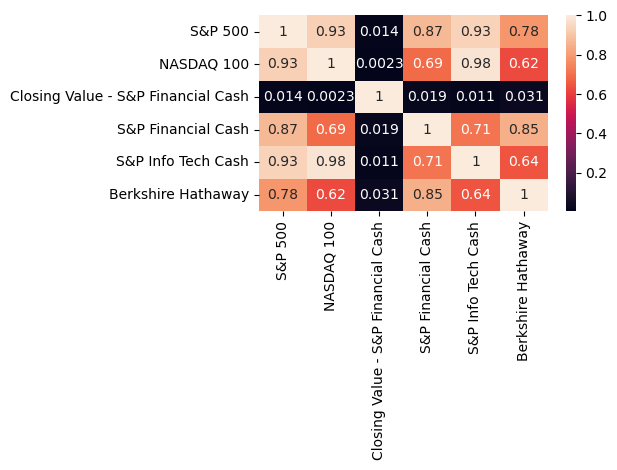

In [4]:
print(all_portfolios[all_portfolios.columns[1:]].corr())
dataplot = sns.heatmap(all_portfolios[all_portfolios.columns[1:]].corr(), annot=True)
plt.tight_layout()
save_path = os.path.join('wykresy', 'korelacje.png')
plt.savefig(save_path)
plt.show()


## Wartości zamknięcia

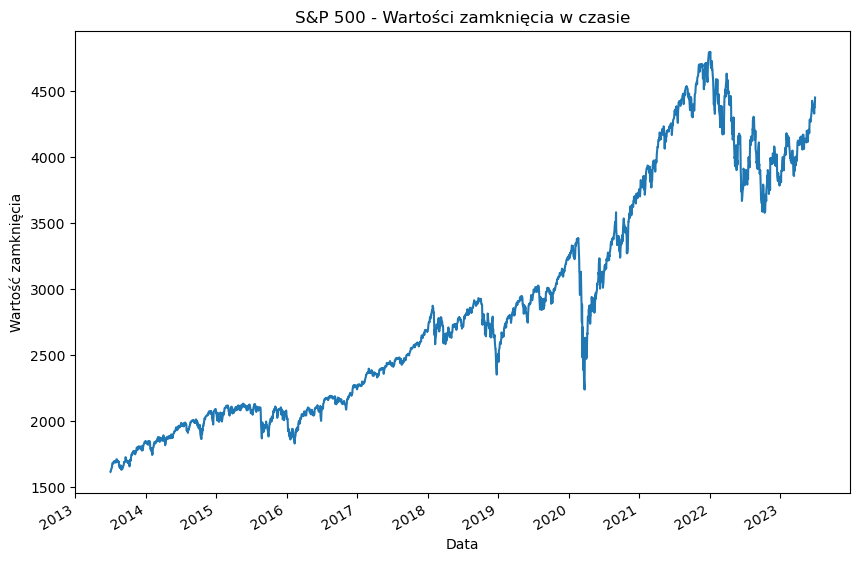

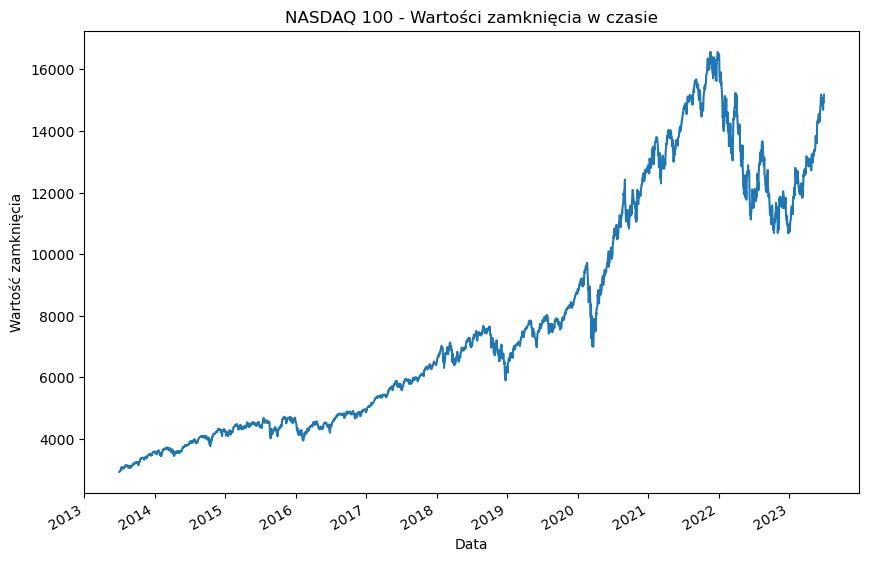

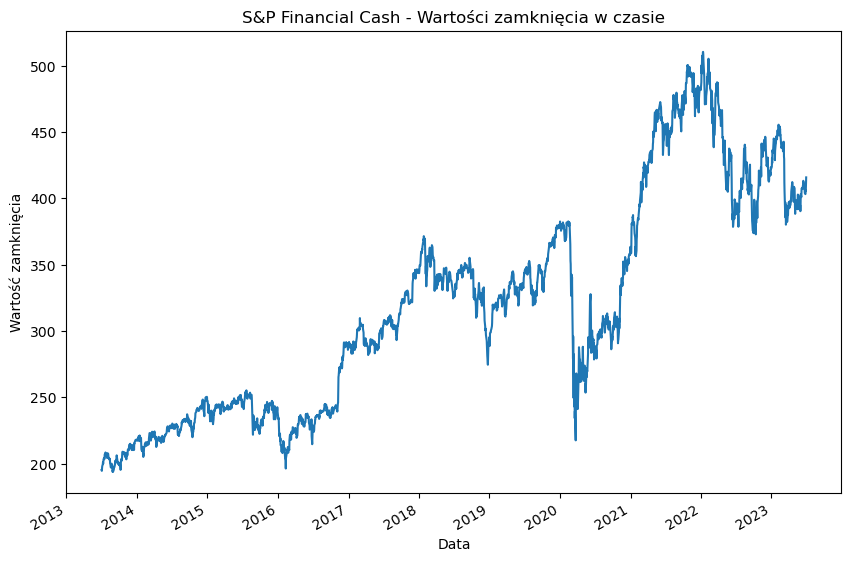

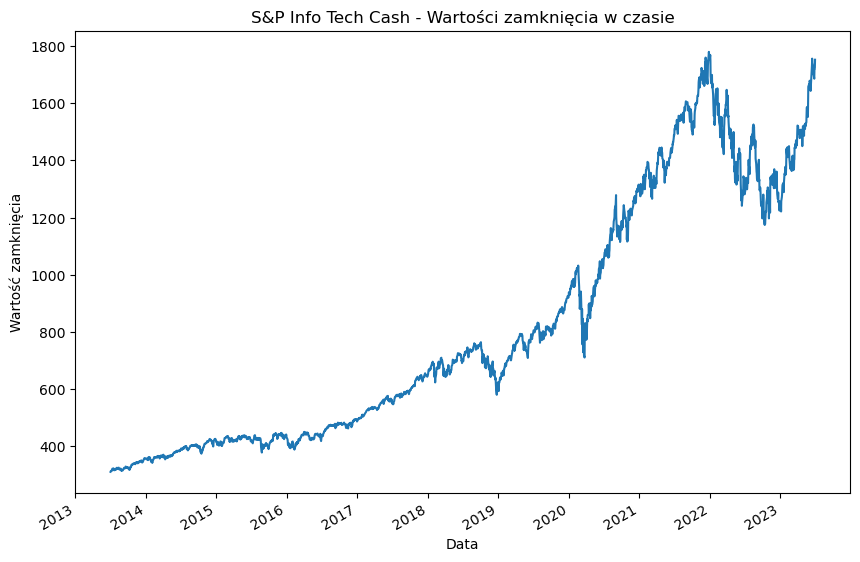

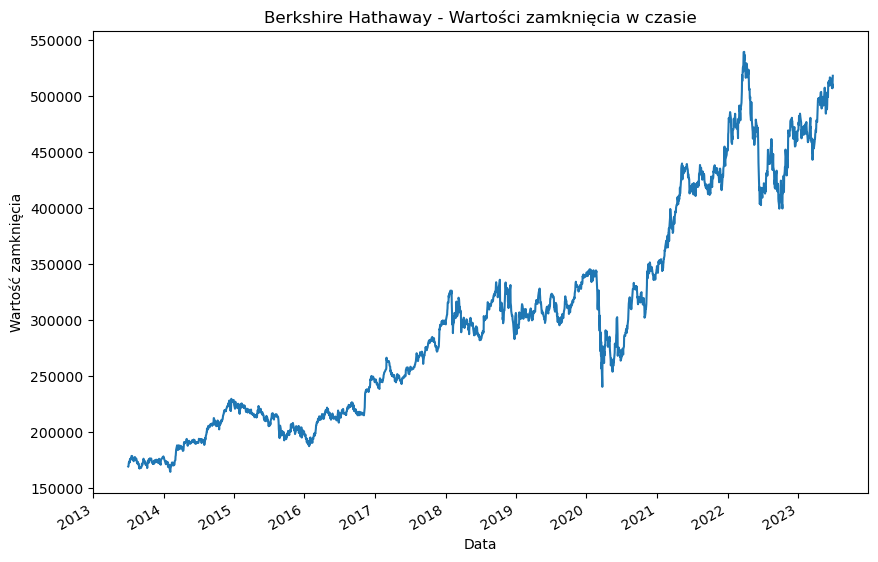

In [5]:
for portfolio in portfolios.values():
    portfolio.plot_closing_values()


## Logarytmiczne stopy zwrotu

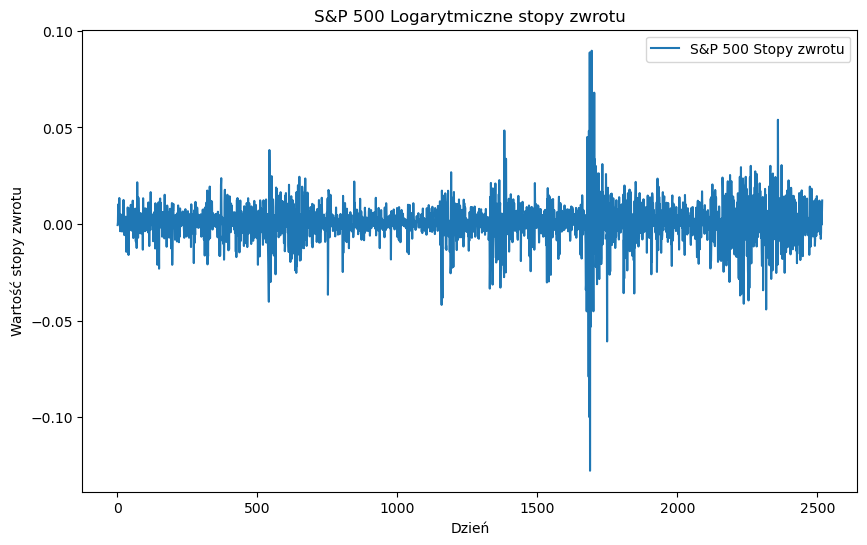

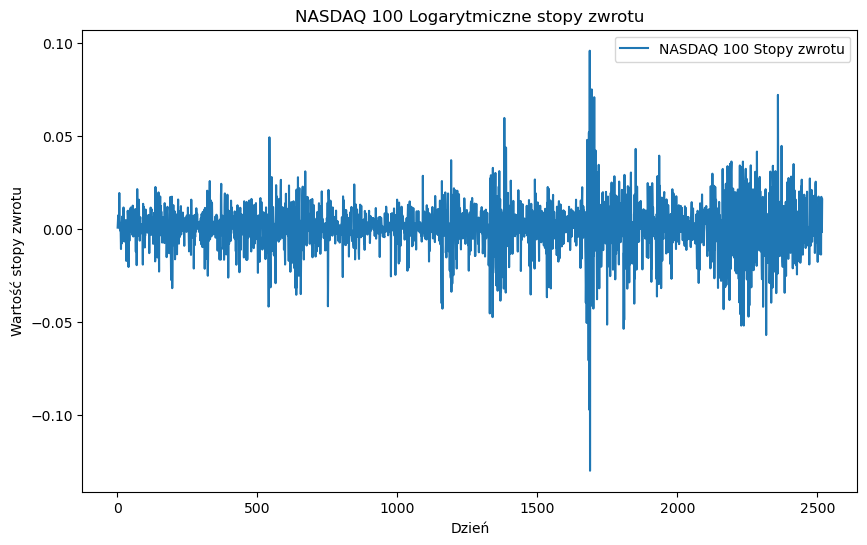

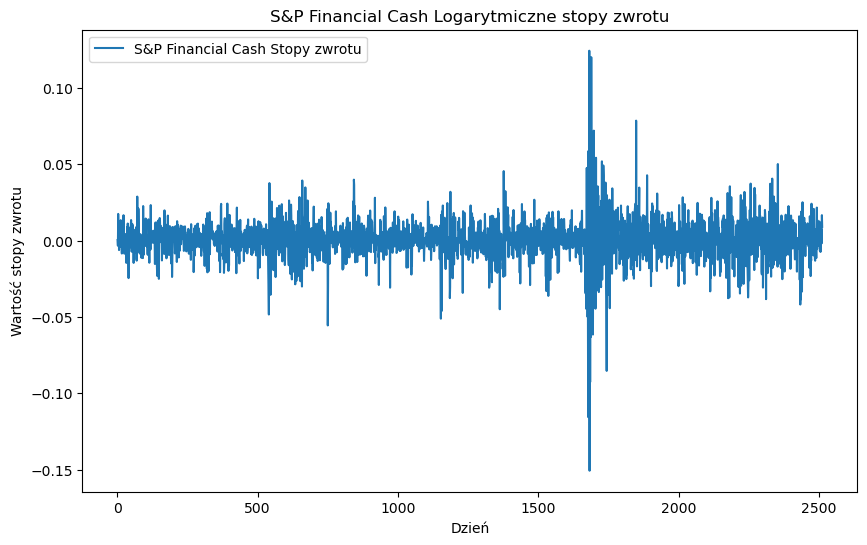

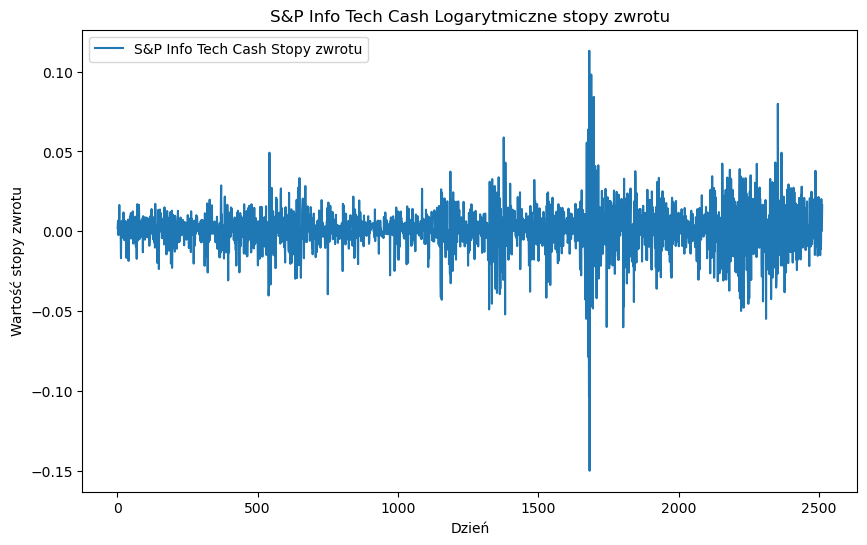

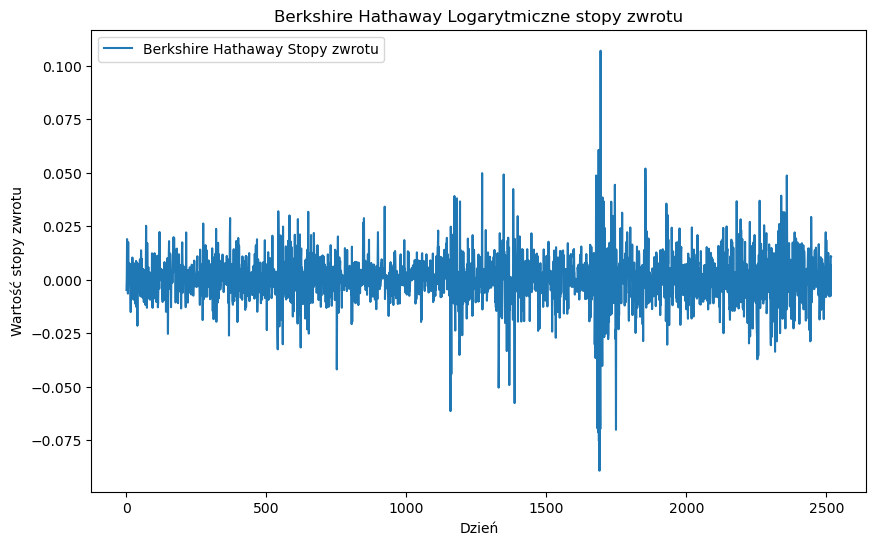

In [6]:
for portfolio in portfolios.values():
    portfolio.plot_return_rates()

## Stacjonarność

In [7]:
for portfolio in portfolios.values():
    portfolio.test_stationarity()


Results for S&P 500:
ADF Statistic: -15.804210213177205
ADF p-value: 1.0652269291222678e-28
ADF Critical Values: {'1%': -3.4329610922579095, '5%': -2.8626935681060375, '10%': -2.567384088736619}
ADF: Reject the null hypothesis. The data is likely stationary.

KPSS Statistic: 0.023848015518191986
KPSS p-value: 0.1
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: Fail to reject the null hypothesis. The data is likely stationary.

Results for NASDAQ 100:
ADF Statistic: -16.31333871757631
ADF p-value: 3.180010861502872e-29
ADF Critical Values: {'1%': -3.4329610922579095, '5%': -2.8626935681060375, '10%': -2.567384088736619}
ADF: Reject the null hypothesis. The data is likely stationary.

KPSS Statistic: 0.04566900481505192
KPSS p-value: 0.1
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: Fail to reject the null hypothesis. The data is likely stationary.

Results for S&P Financial Cash:
ADF Statistic: -10.28225997886282

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside 

## Autokorelacja

<Figure size 1000x600 with 0 Axes>

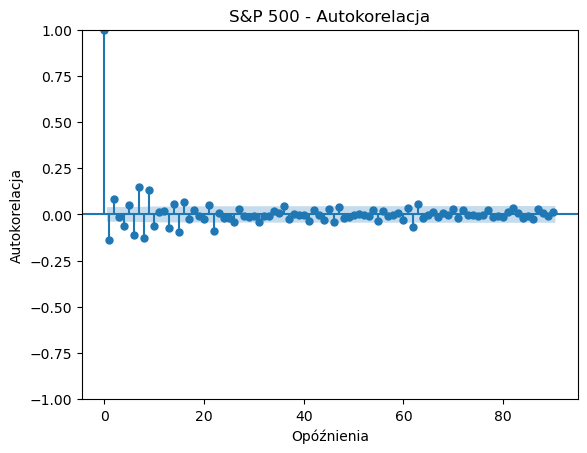

<Figure size 1000x600 with 0 Axes>

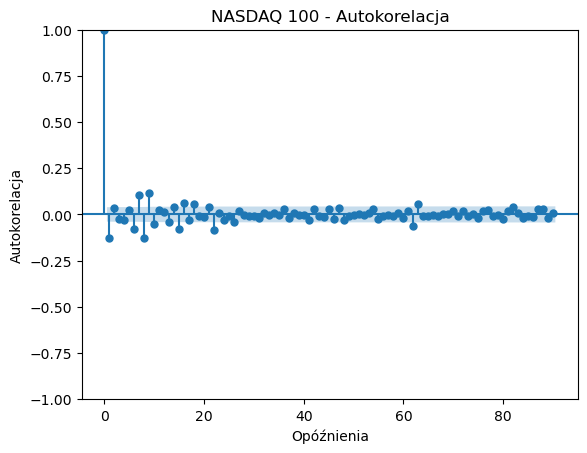

<Figure size 1000x600 with 0 Axes>

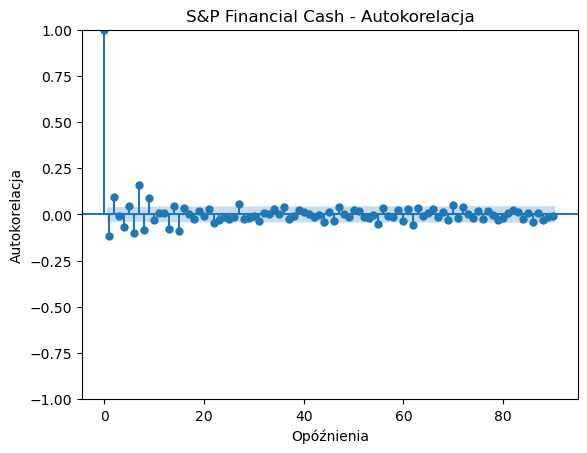

<Figure size 1000x600 with 0 Axes>

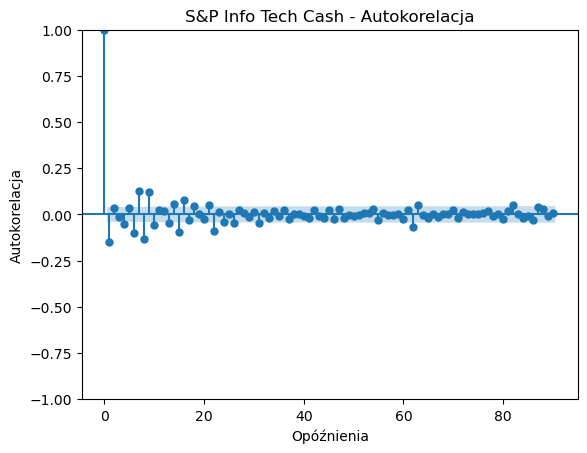

<Figure size 1000x600 with 0 Axes>

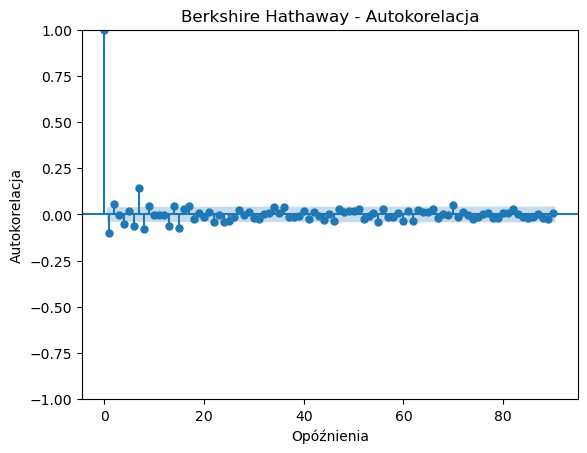

In [8]:
for portfolio in portfolios.values():
    portfolio.plot_autocorrelation()

## Normalność 

In [9]:
for portfolio in portfolios.values():
    portfolio.test_normality()

Results for S&P 500:

Shapiro-Wilk: ShapiroResult(statistic=0.87143874168396, pvalue=2.0426727714462858e-41)

Anderson-Darling: AndersonResult(statistic=55.929922605360844, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0004027331335815432, scale=0.011176181295103471)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Jarque-Bera: SignificanceResult(statistic=28073.777206190505, pvalue=0.0)

----------------------------------------
Results for NASDAQ 100:

Shapiro-Wilk: ShapiroResult(statistic=0.9225699305534363, pvalue=3.7253539673406945e-34)

Anderson-Darling: AndersonResult(statistic=40.98312080341884, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0006538852409747297, scale=0.013631859755311558)
 success: True
 message: '`anderson` su

## Efekt dnia tygodnia

In [10]:
for portfolio in portfolios.values():
    portfolio.weekday_effect()

result = pd.DataFrame({
    'Dzień tygodnia': ['Piątek', 'Poniedziałek', 'Czwartek', 'Wtorek', 'Środa'],
    'S&P 500': portfolios['SPX'].weekday_effect.values,
    'NASDAQ 100': portfolios['NDX'].weekday_effect.values,
    'S&P Financial Cash': portfolios['BN'].weekday_effect.values,
    'S&P Info Tech Cash': portfolios['JB'].weekday_effect.values,
    'Berkshire Hathaway': portfolios['BRK'].weekday_effect.values
})

result = result.set_index('Dzień tygodnia')
result = result.reindex(['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek'])

print(result)


                    S&P 500   NASDAQ 100  S&P Financial Cash  \
Dzień tygodnia                                                 
Poniedziałek    2855.624064  7834.587640          317.643006   
Wtorek          2869.362254  7885.645017          319.318685   
Środa           2871.956764  7900.321620          319.414494   
Czwartek        2874.356890  7911.173805          319.222067   
Piątek          2869.009861  7871.767990          319.337302   

                S&P Info Tech Cash  Berkshire Hathaway  
Dzień tygodnia                                          
Poniedziałek            810.193710       298764.929255  
Wtorek                  817.533520       300652.827013  
Środa                   818.924825       300946.197112  
Czwartek                818.824469       301132.107087  
Piątek                  814.979167       301048.801706  


C:\Users\Julia.Przepiora\AppData\Local\Temp\ipykernel_27520\3704594481.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.weekday_effect = self.data.groupby(['Week Day']).mean()['Zamkniecie']
C:\Users\Julia.Przepiora\AppData\Local\Temp\ipykernel_27520\3704594481.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.weekday_effect = self.data.groupby(['Week Day']).mean()['Zamkniecie']
C:\Users\Julia.Przepiora\AppData\Local\Temp\ipykernel_27520\3704594481.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to

### ANOVA

In [11]:
for name, portfolio in portfolios.items():
    portfolio.anova()
    print(f"ANOVA results for {name}:")
    print(portfolio.anova_result)
    print("\n")

ANOVA results for SPX:
                   sum_sq      df         F    PR(>F)
C(Week_Day)  1.018924e+05     4.0  0.033062  0.997906
Residual     1.935398e+09  2512.0       NaN       NaN


ANOVA results for NDX:
                   sum_sq      df        F    PR(>F)
C(Week_Day)  1.721120e+06     4.0  0.02904  0.998376
Residual     3.721981e+10  2512.0      NaN       NaN


ANOVA results for BN:
                   sum_sq      df         F    PR(>F)
C(Week_Day)  1.086606e+03     4.0  0.039565  0.997027
Residual     1.721300e+07  2507.0       NaN       NaN


ANOVA results for JB:
                   sum_sq      df         F    PR(>F)
C(Week_Day)  2.590523e+04     4.0  0.035205  0.997633
Residual     4.611874e+08  2507.0       NaN       NaN


ANOVA results for BRK:
                   sum_sq      df         F    PR(>F)
C(Week_Day)  1.881200e+09     4.0  0.050288  0.995266
Residual     2.349246e+13  2512.0       NaN       NaN




### Boxplot

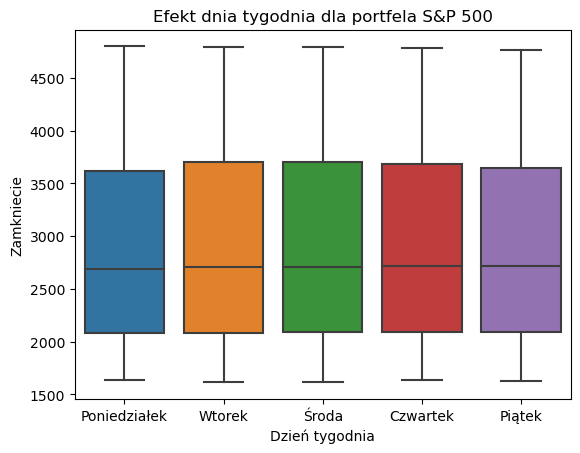

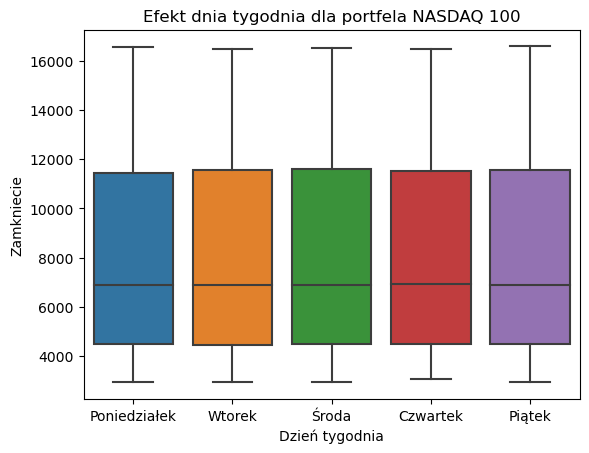

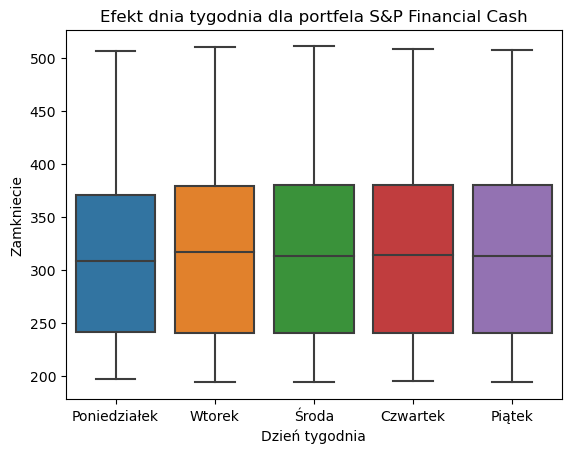

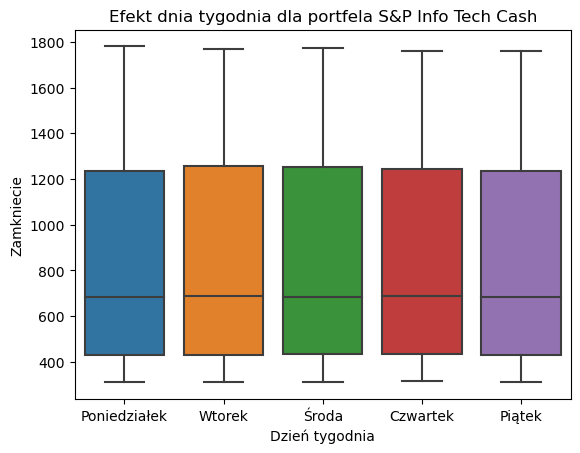

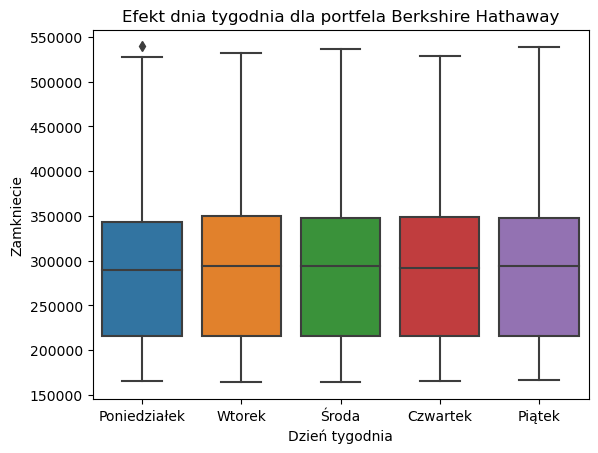

In [12]:
for portfolio in portfolios.values():
    portfolio.weekday_boxplots()

## Szybka transformata Fouriera (FFT)

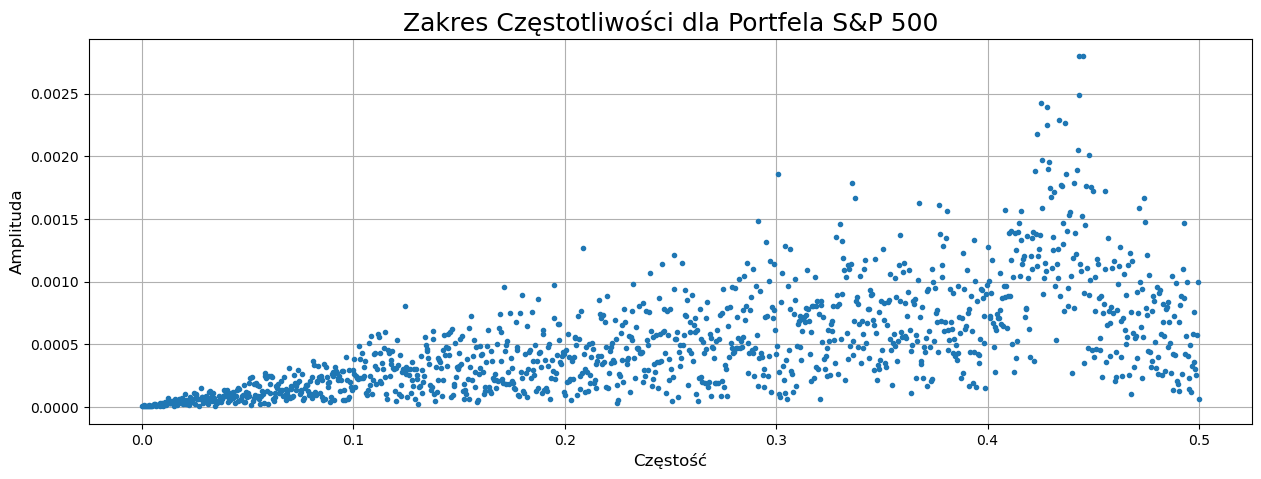

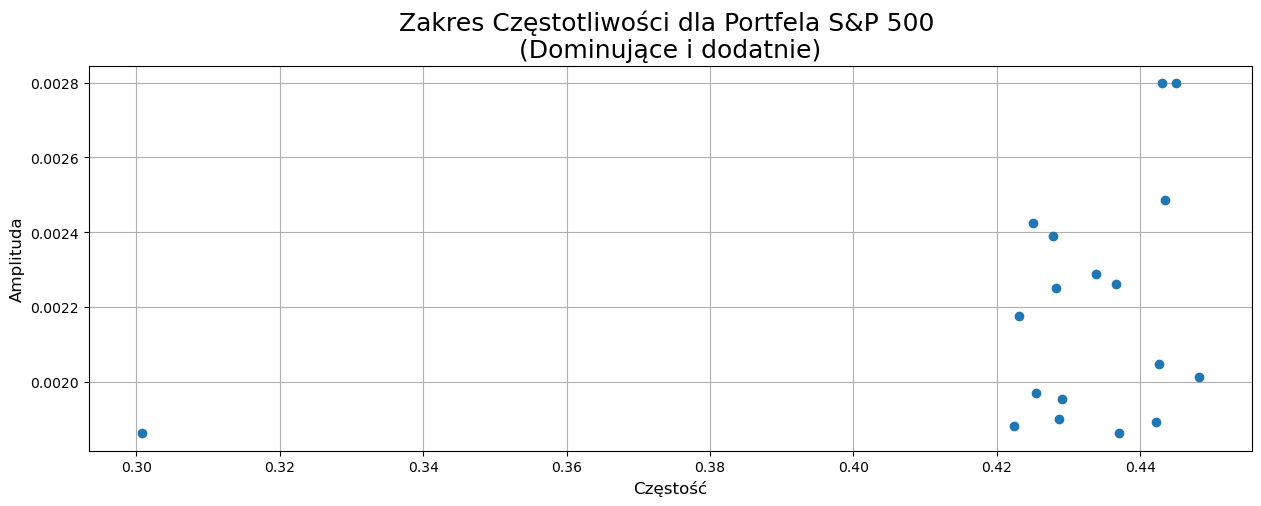

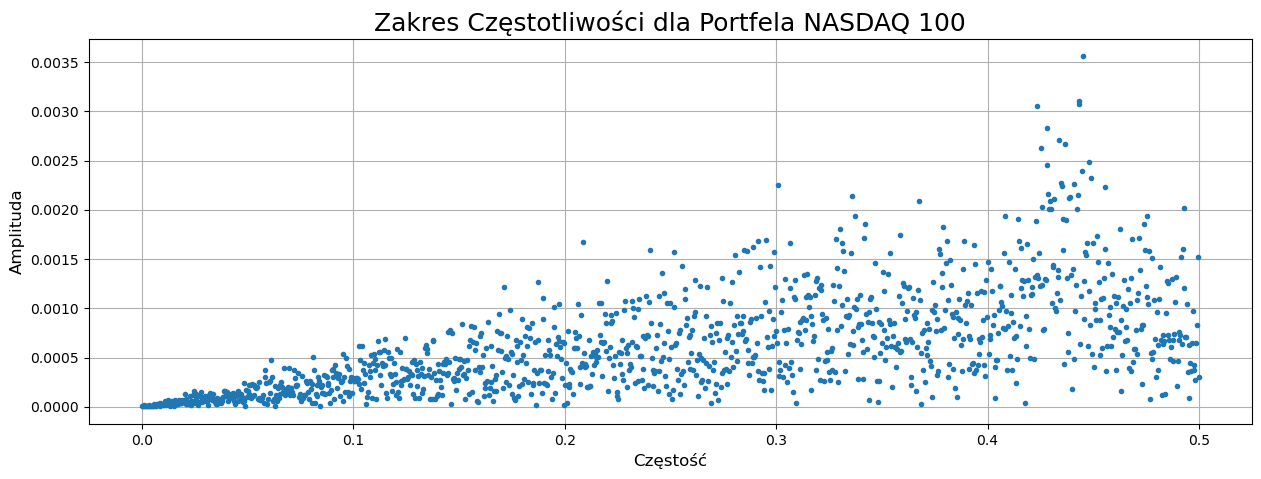

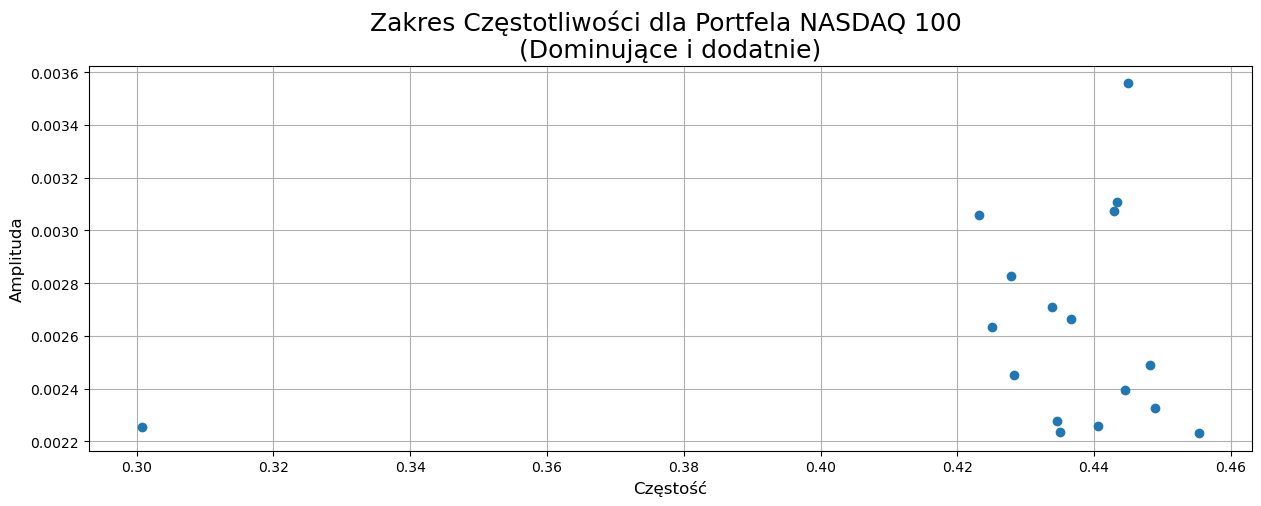

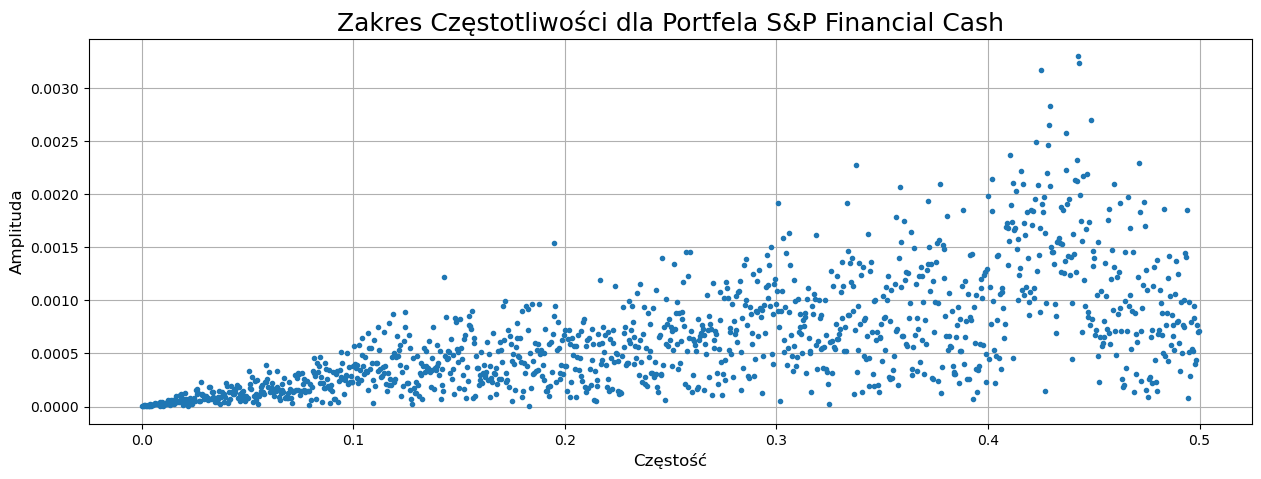

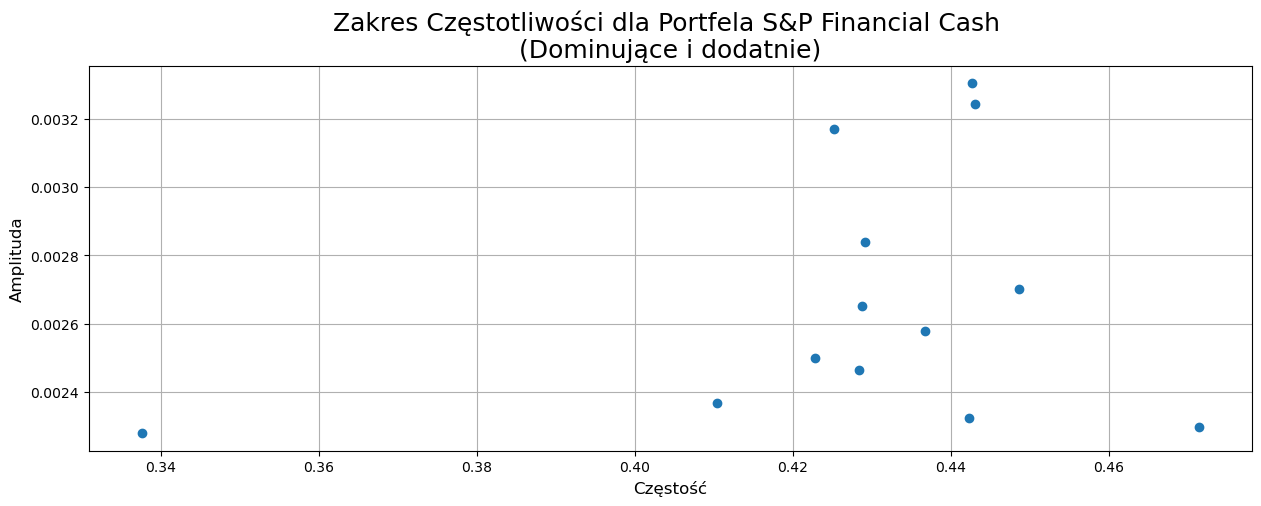

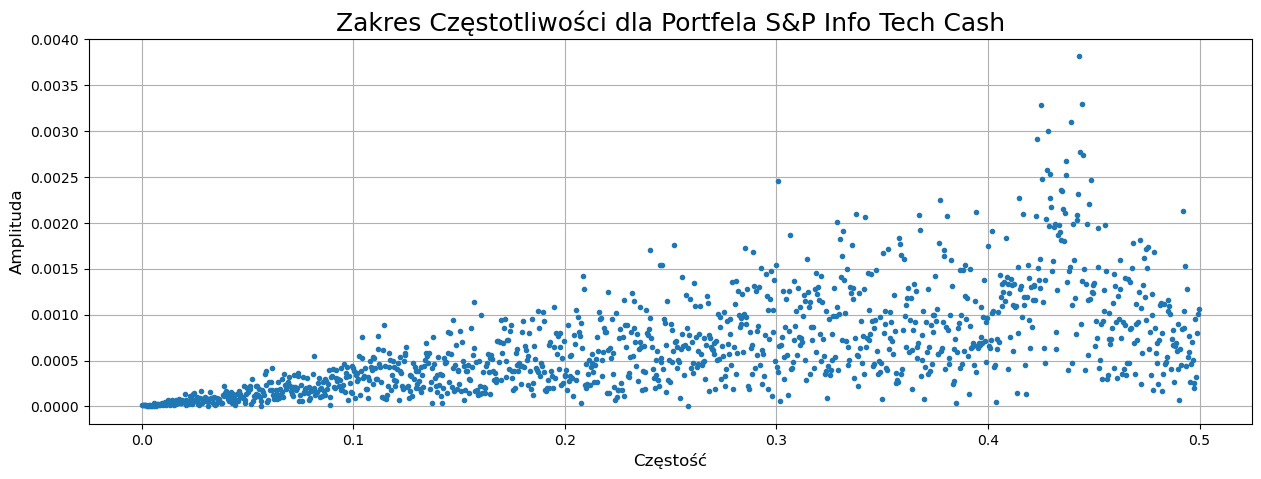

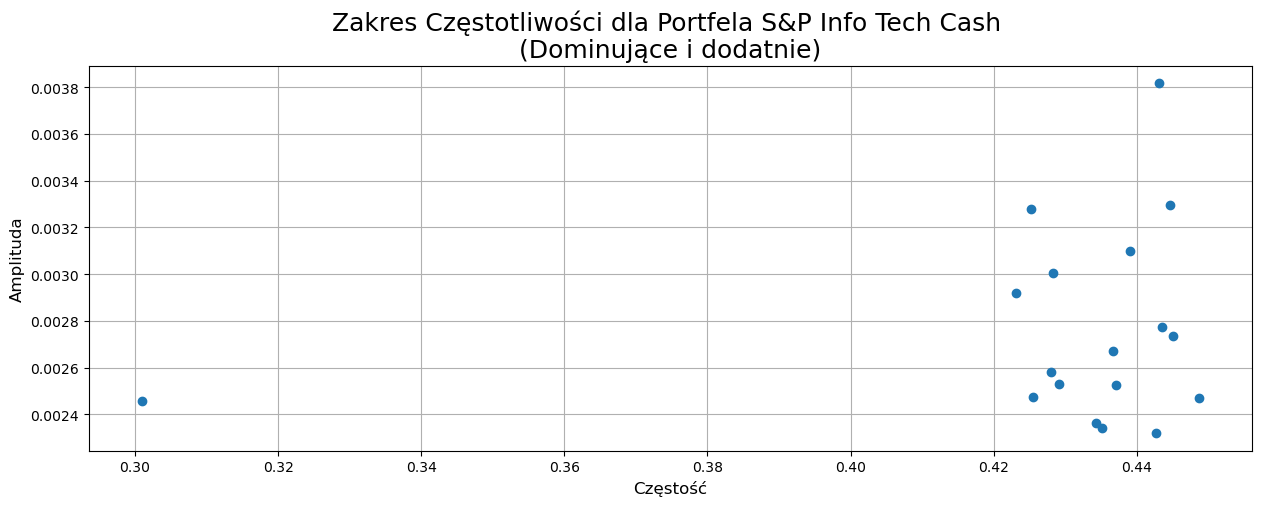

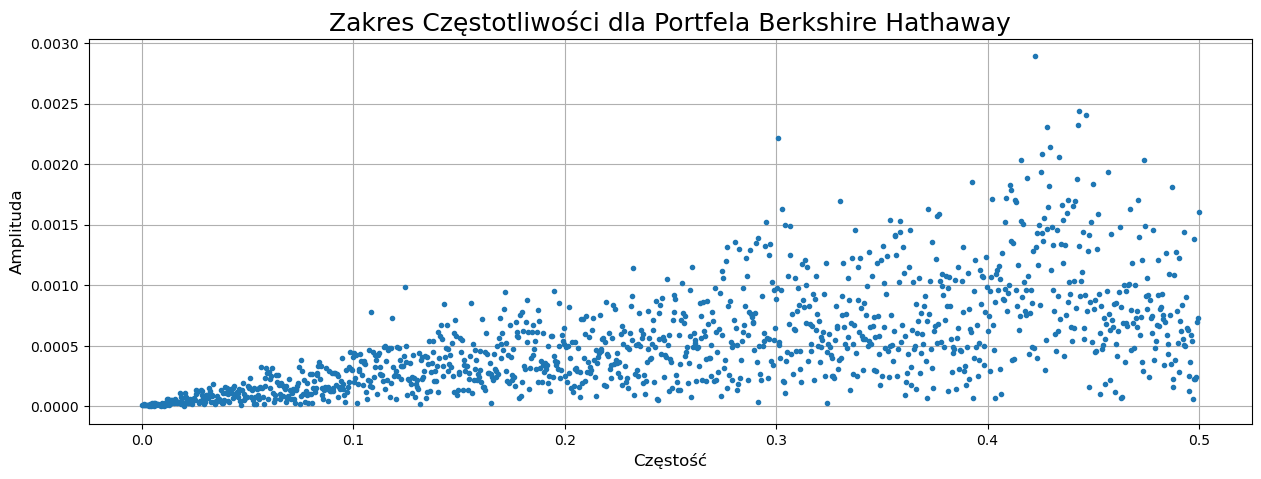

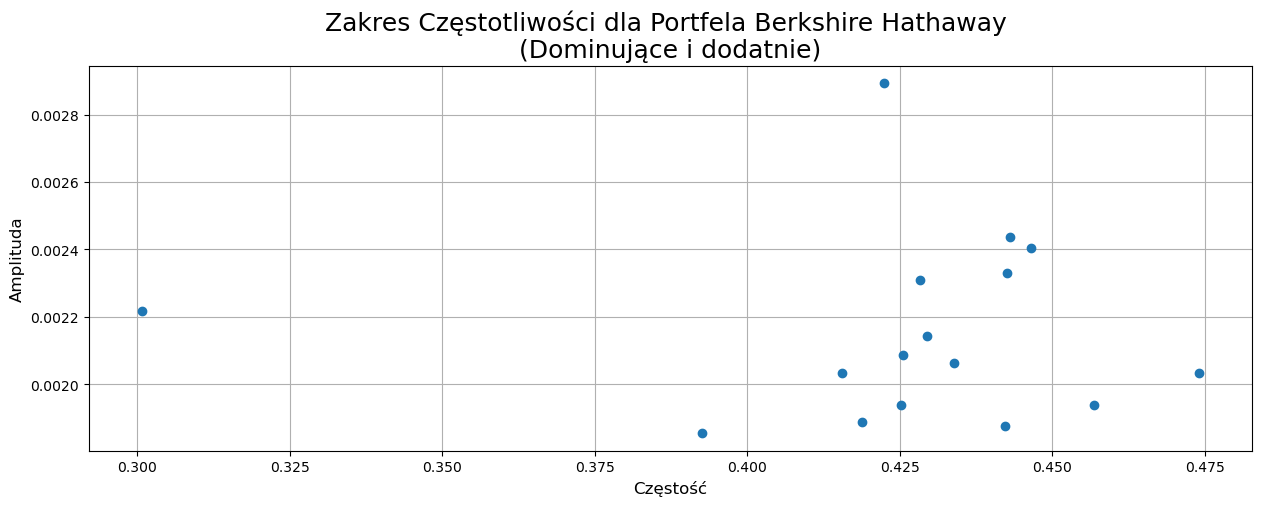

In [13]:
for portfolio in portfolios.values():
    portfolio.fast_fourier_transform()

## Dekompozycja

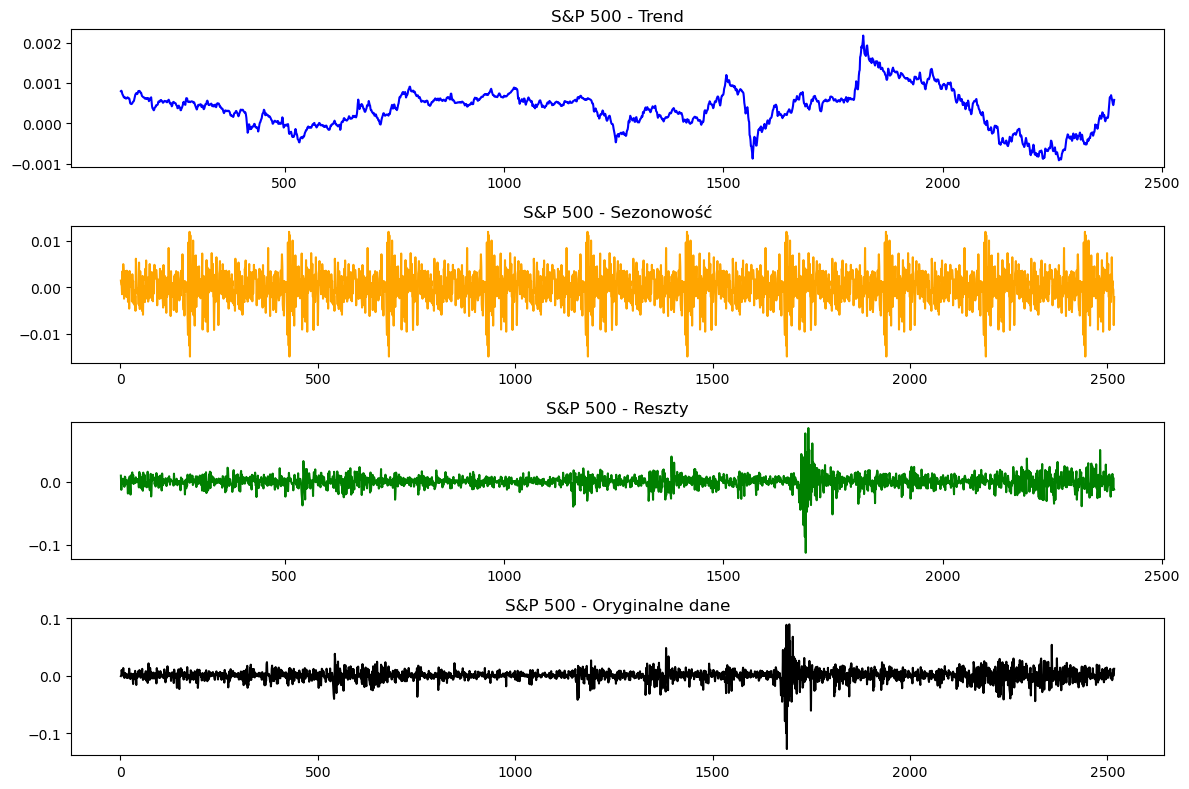

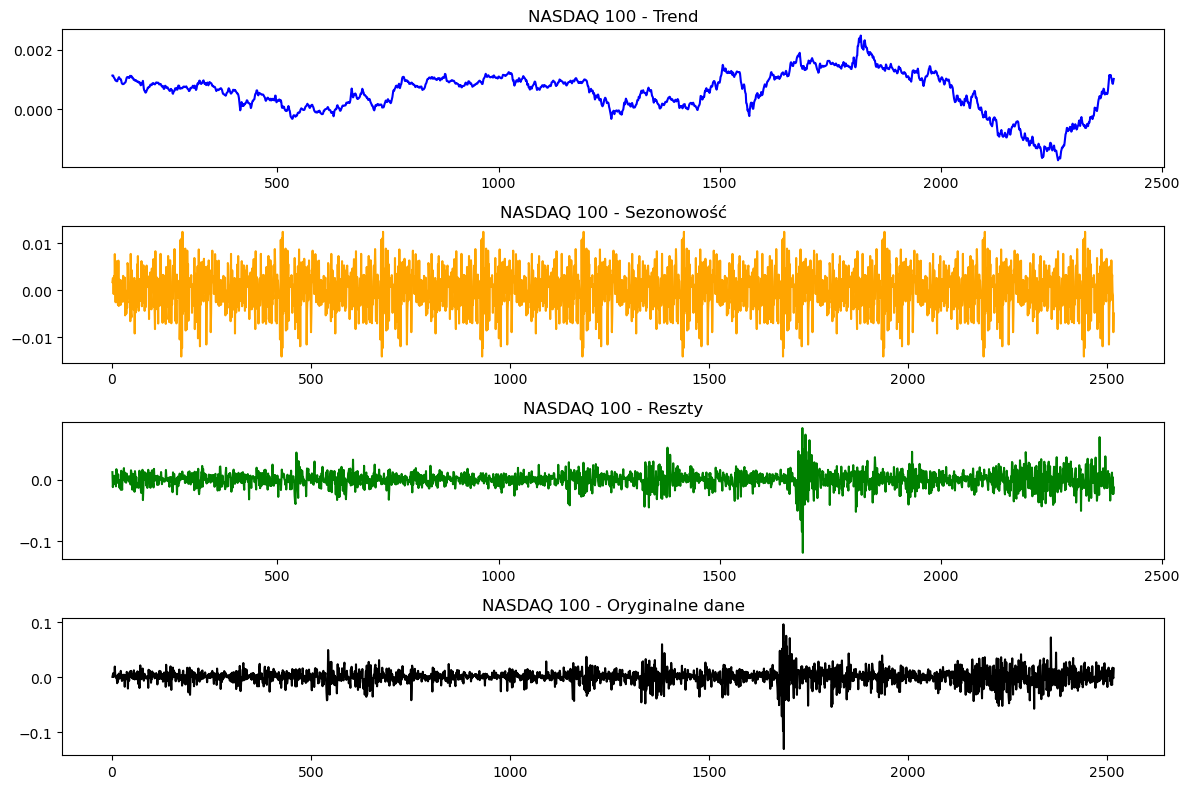

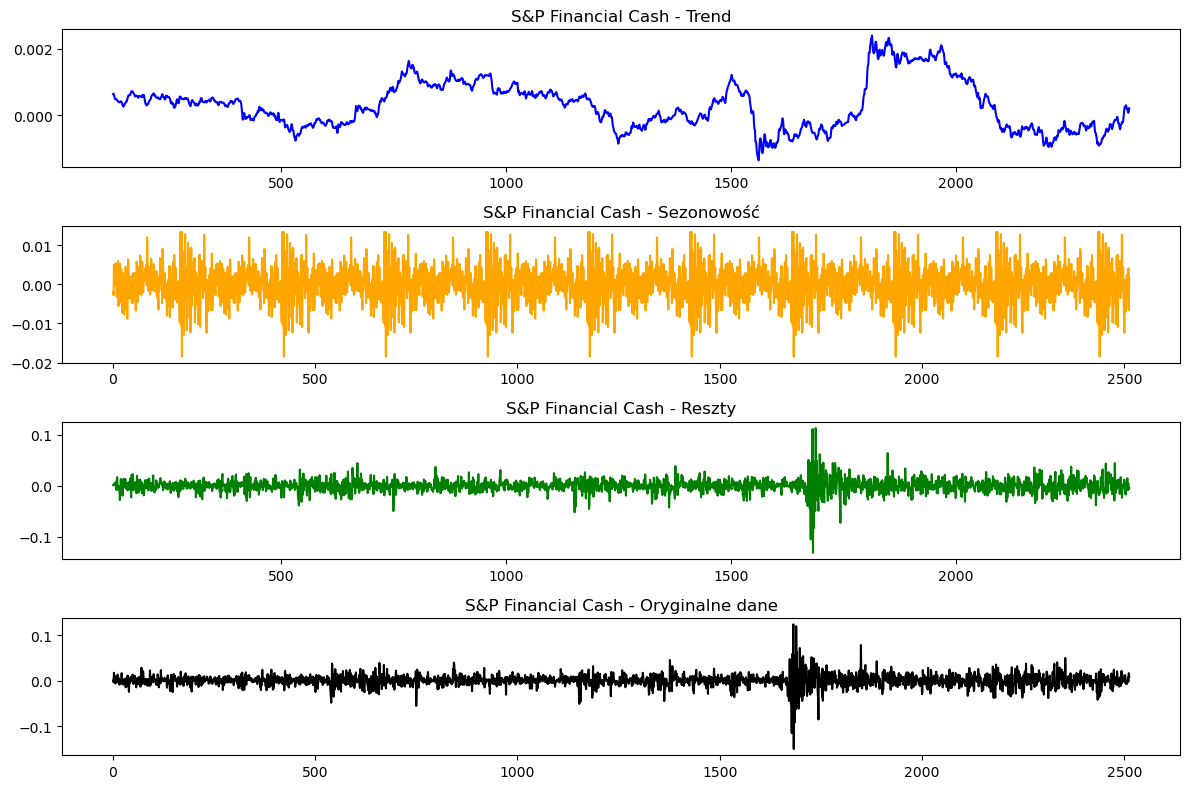

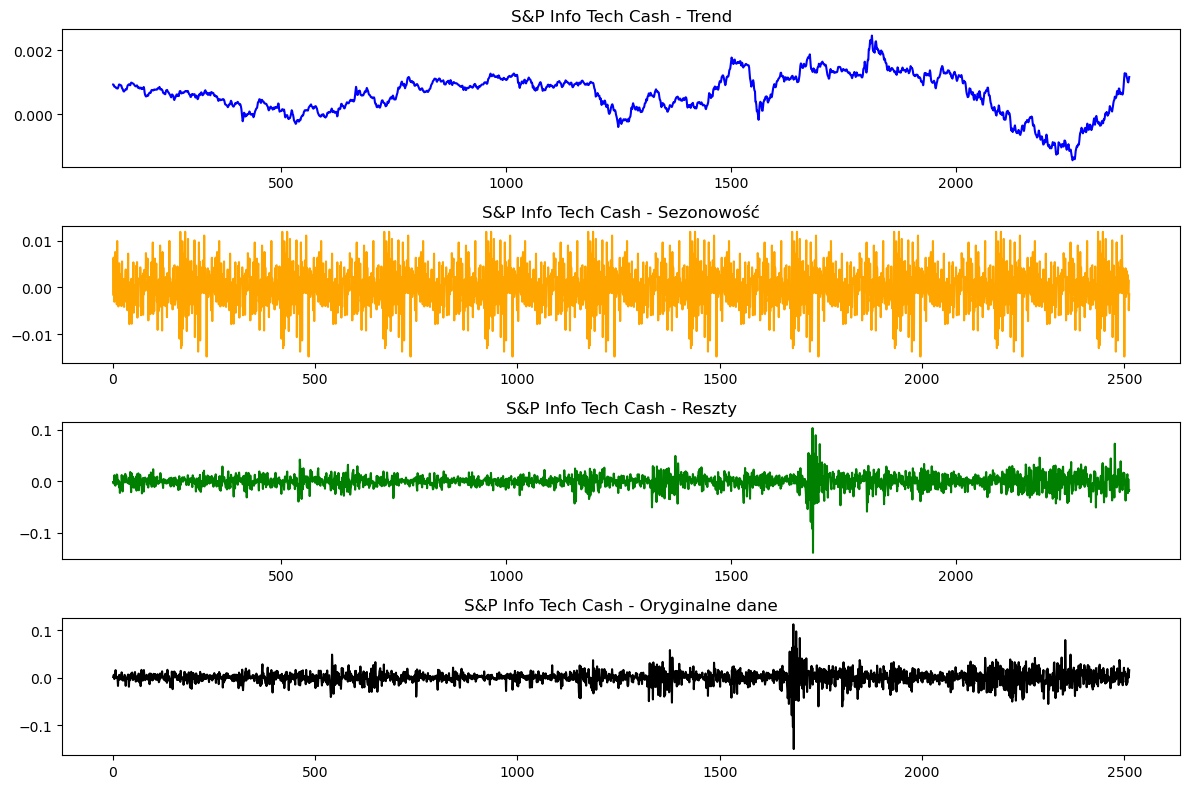

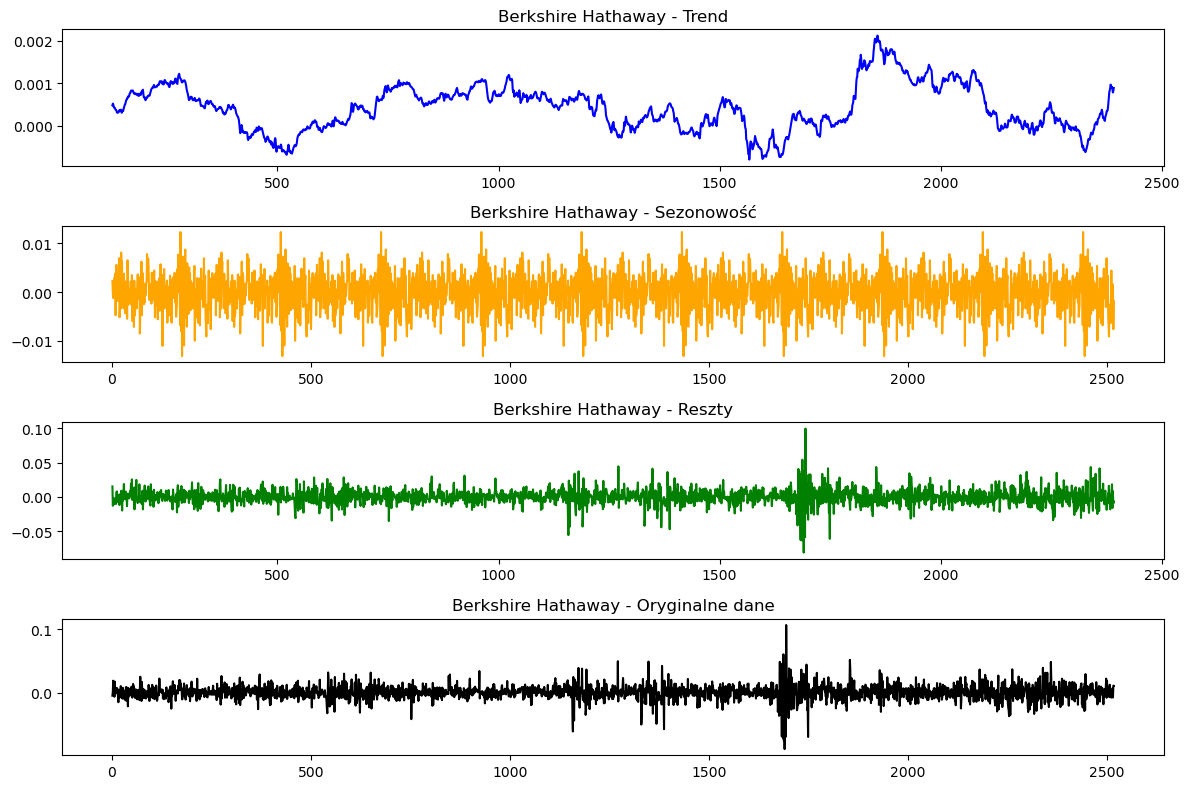

In [14]:
for portfolio in portfolios.values():
    portfolio.decompose()


## Periodogramy

### Naiwny

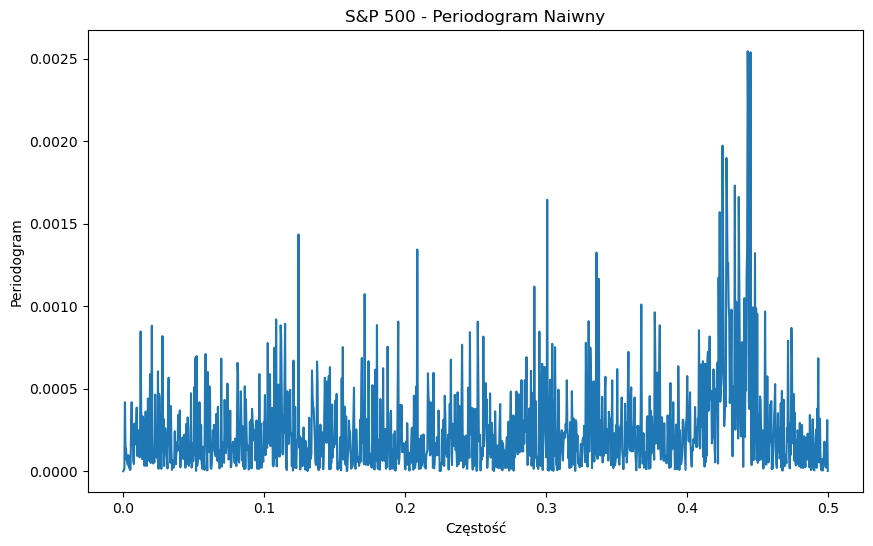

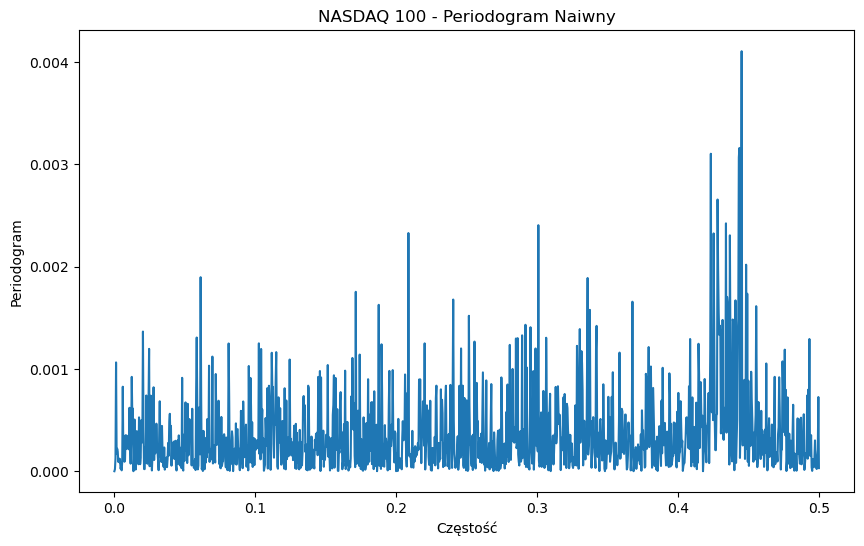

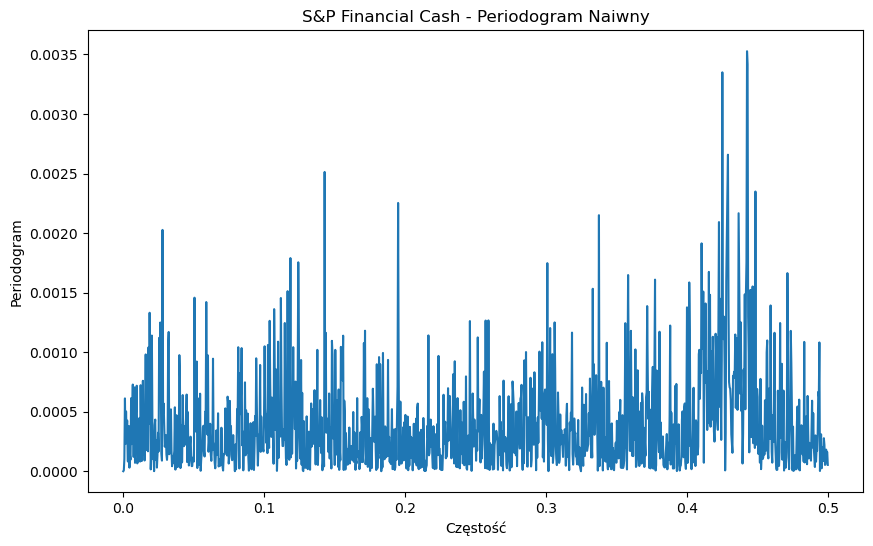

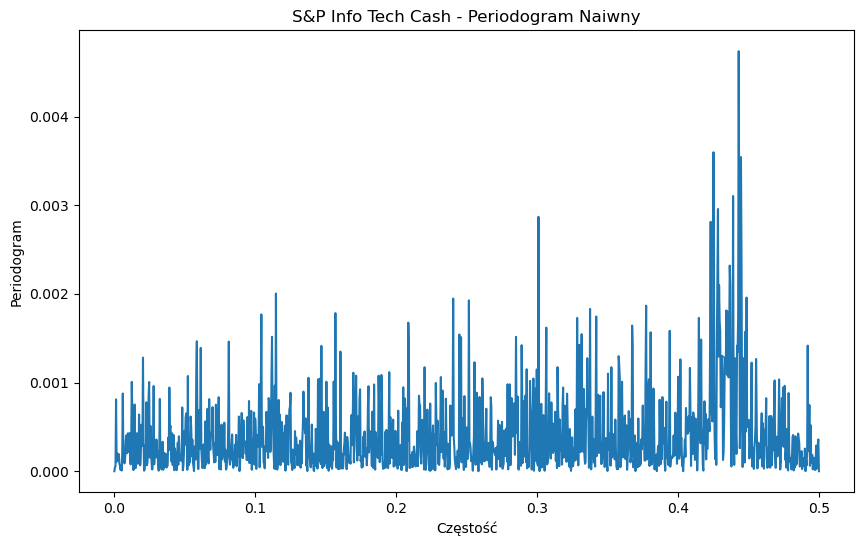

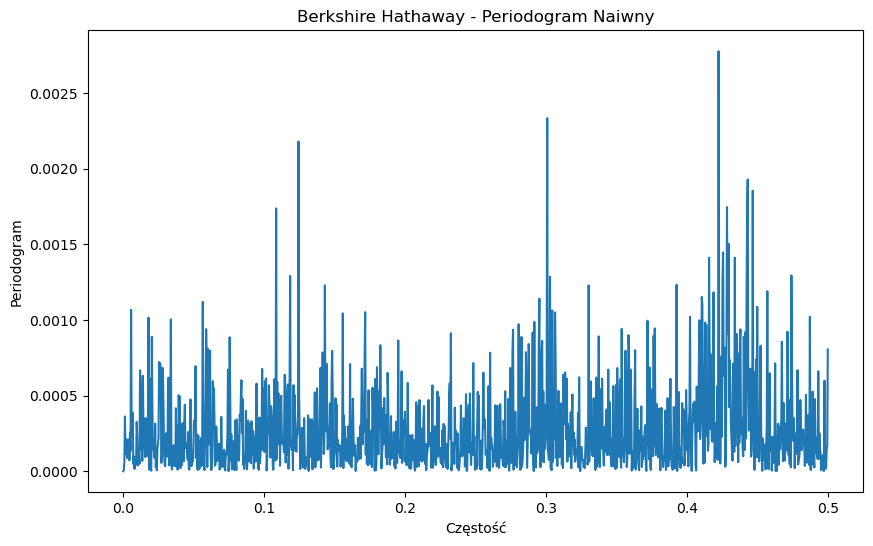

In [15]:
for portfolio in portfolios.values():
    portfolio.naive_periodogram()

### Welcha

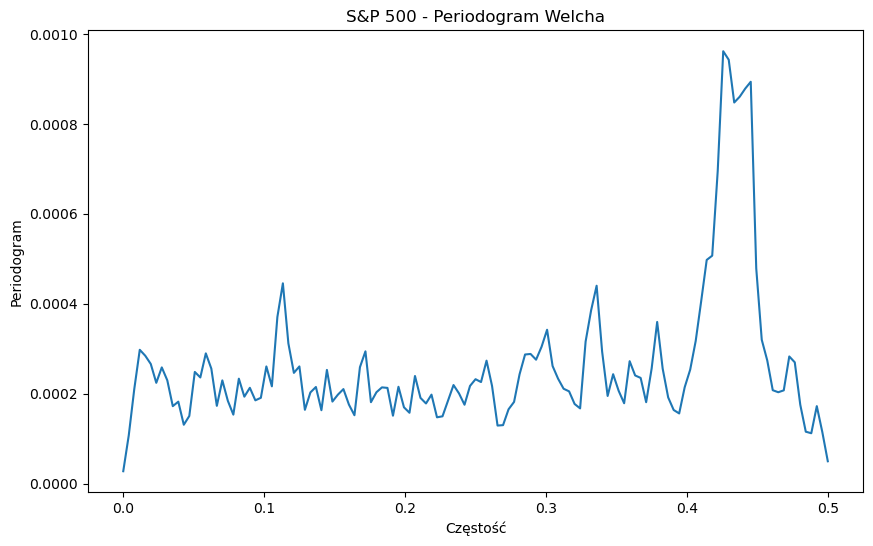

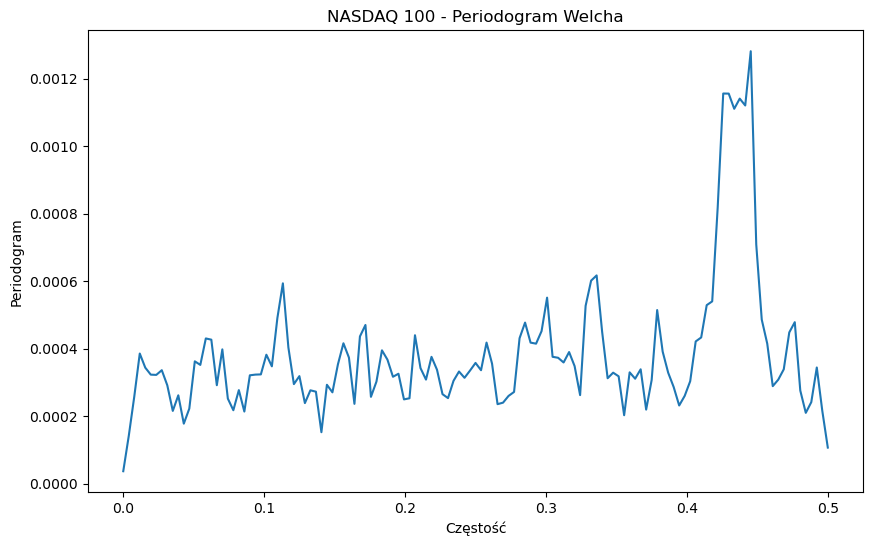

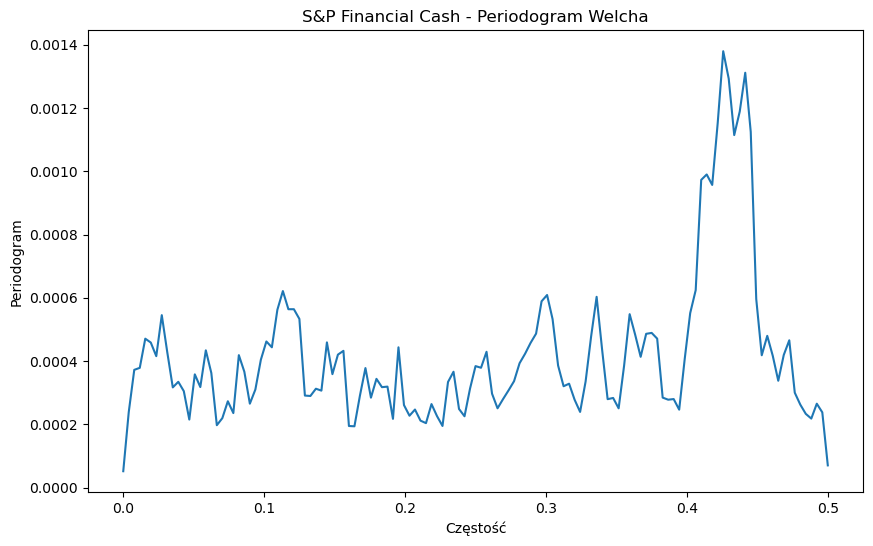

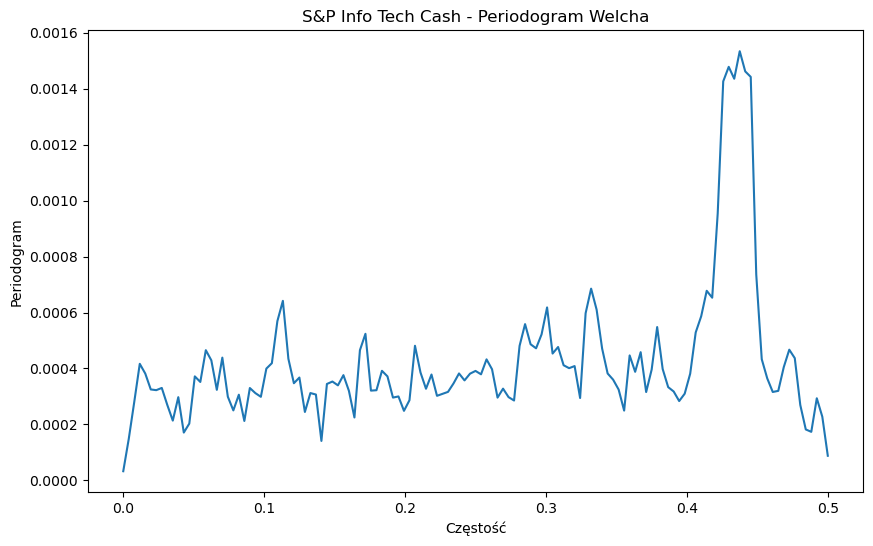

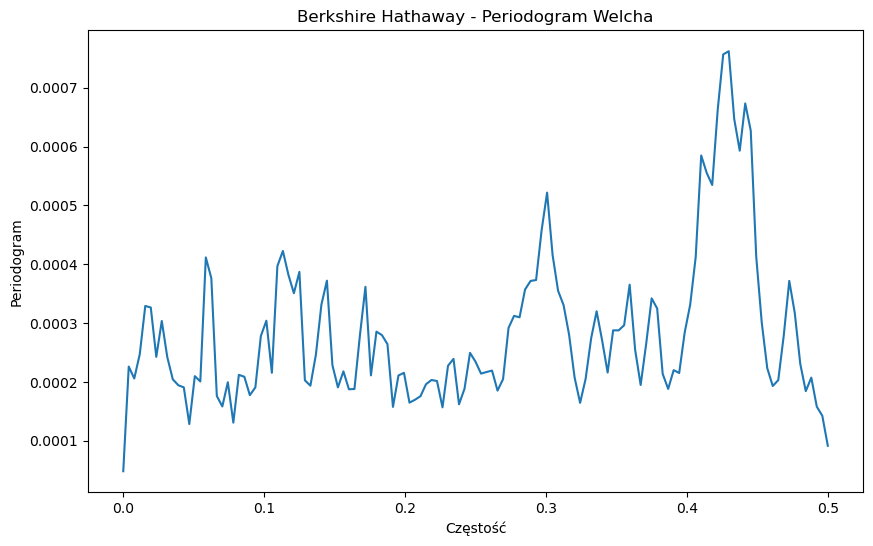

In [16]:
for portfolio in portfolios.values():
    portfolio.welch_periodogram()

### Z oknem Daniella

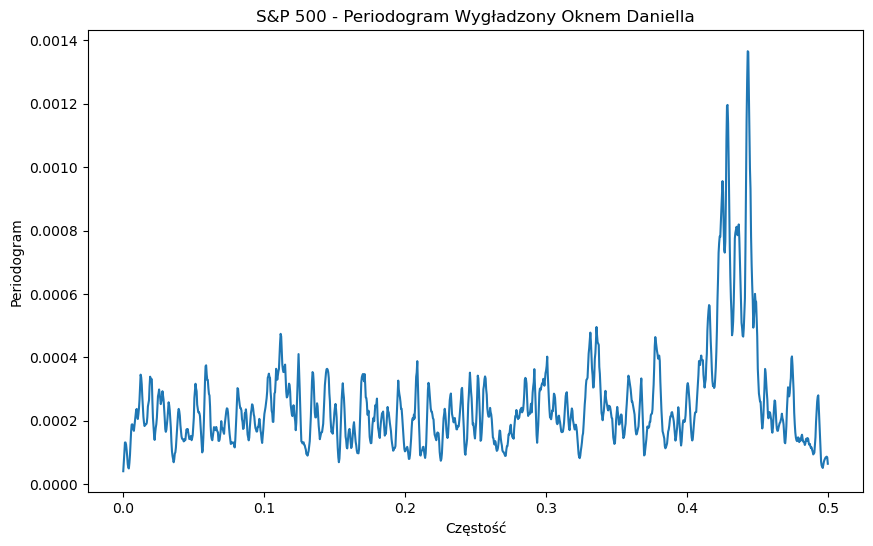

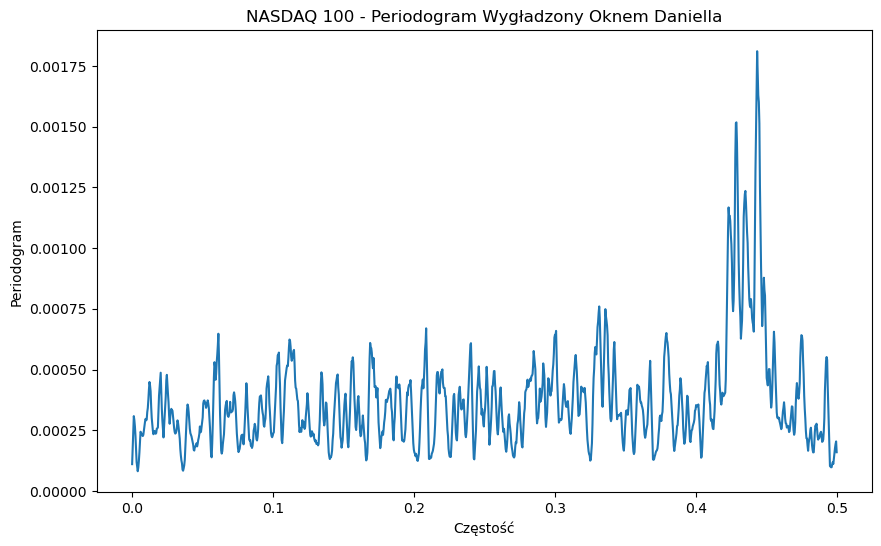

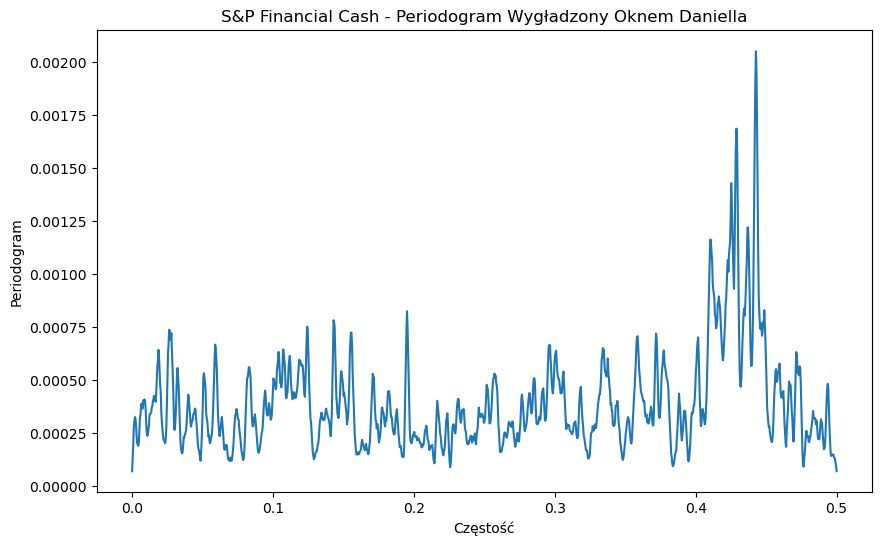

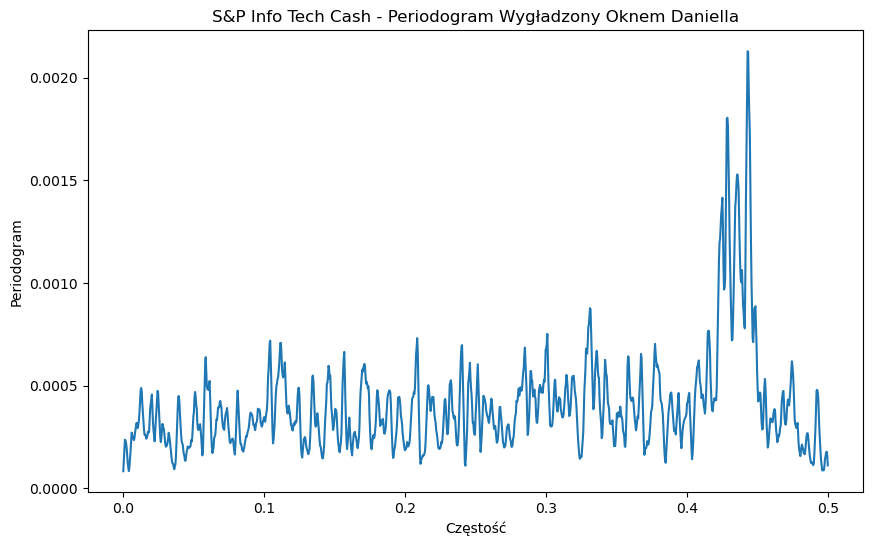

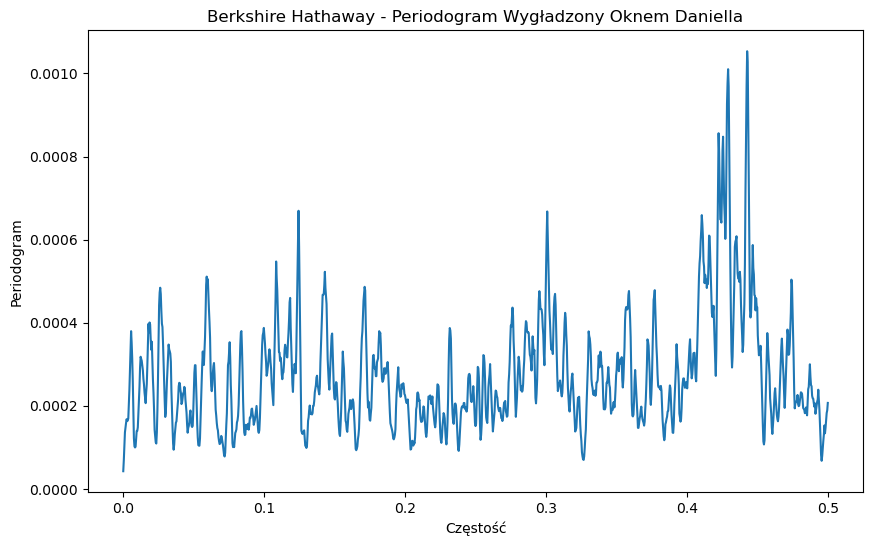

In [17]:
for portfolio in portfolios.values():
    portfolio.daniell_periodogram()

## Analiza falkowa Morleta

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


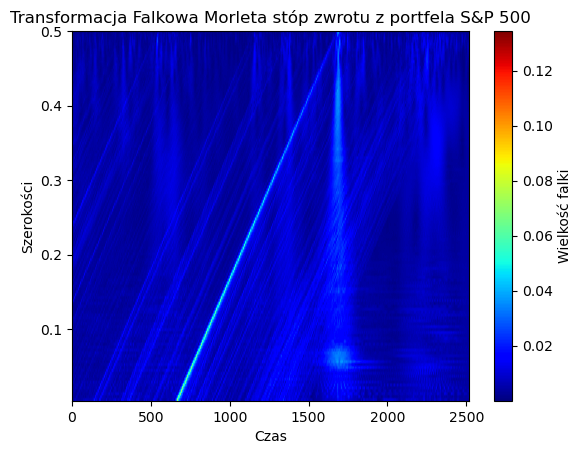

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


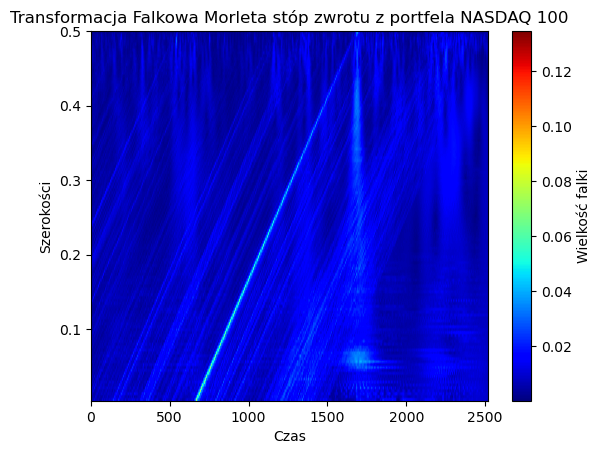

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


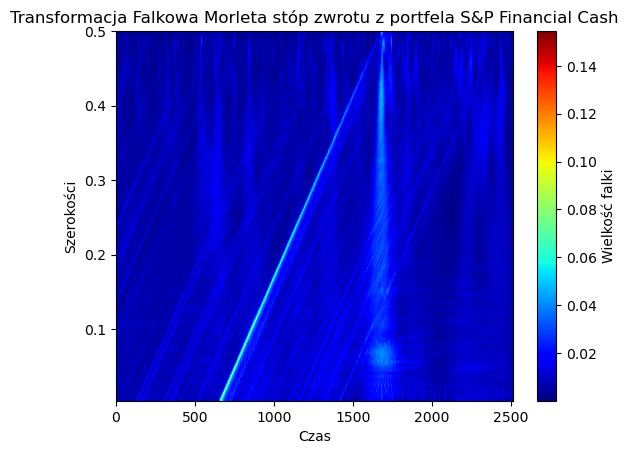

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


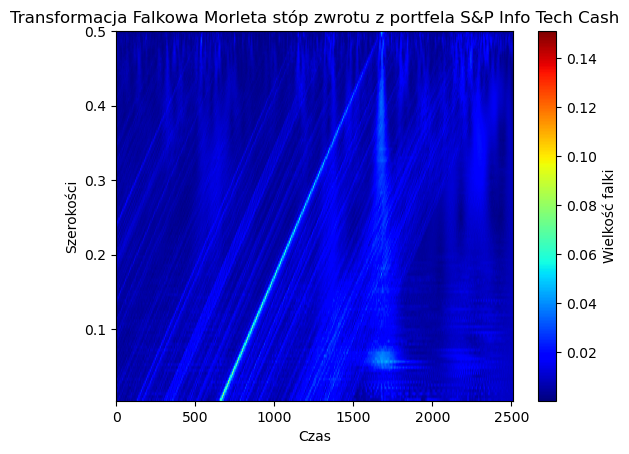

c:\Users\Julia.Przepiora\Anaconda3\envs\Py310\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


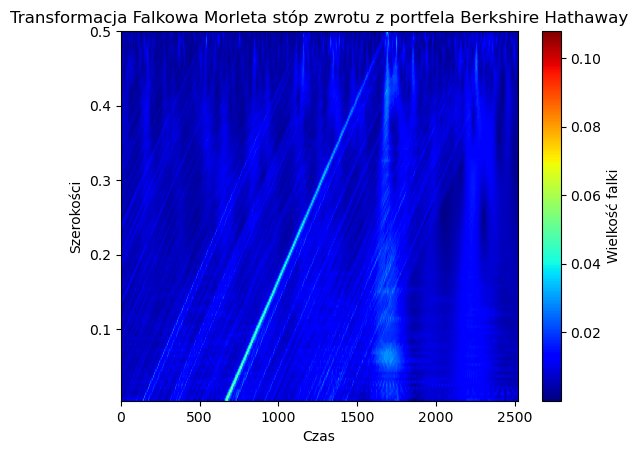

In [18]:
for portfolio in portfolios.values():
    portfolio.morlet_wavelet()

## EMA (Exponential Moving Average)
 Golden Cross i Death Cross

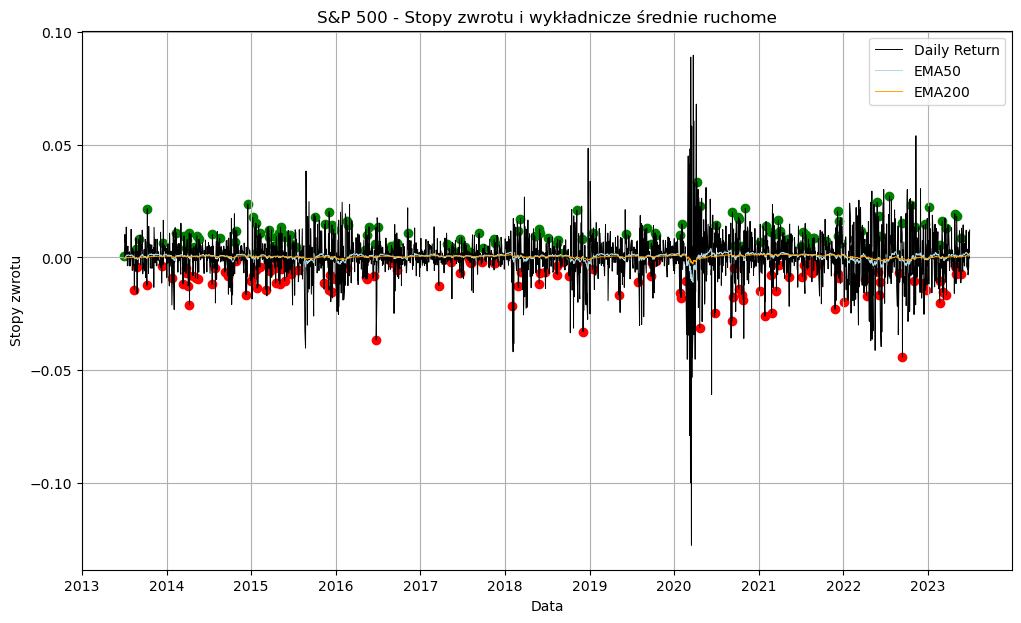

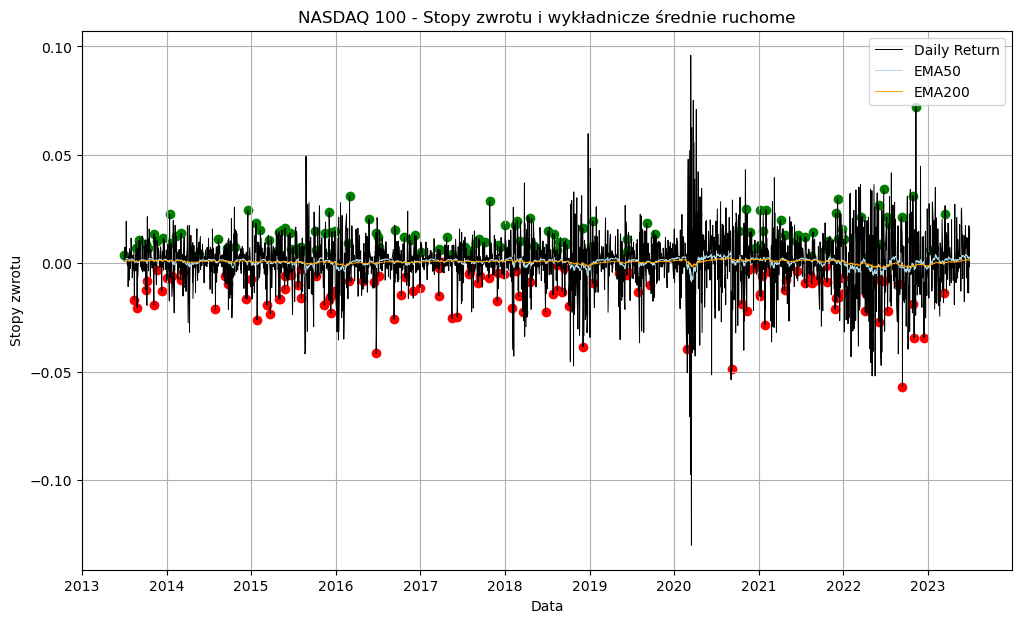

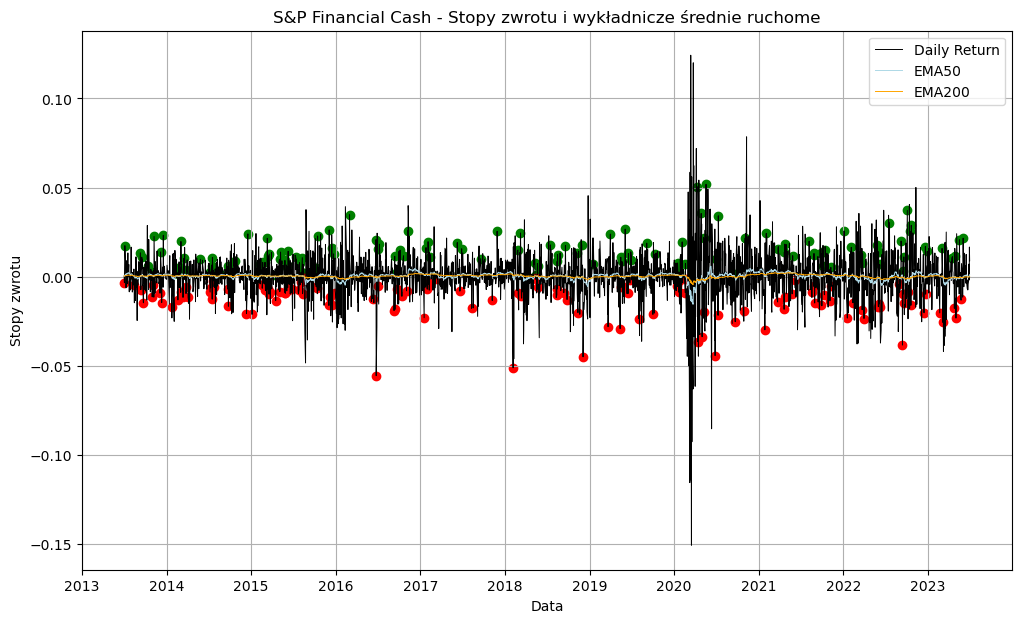

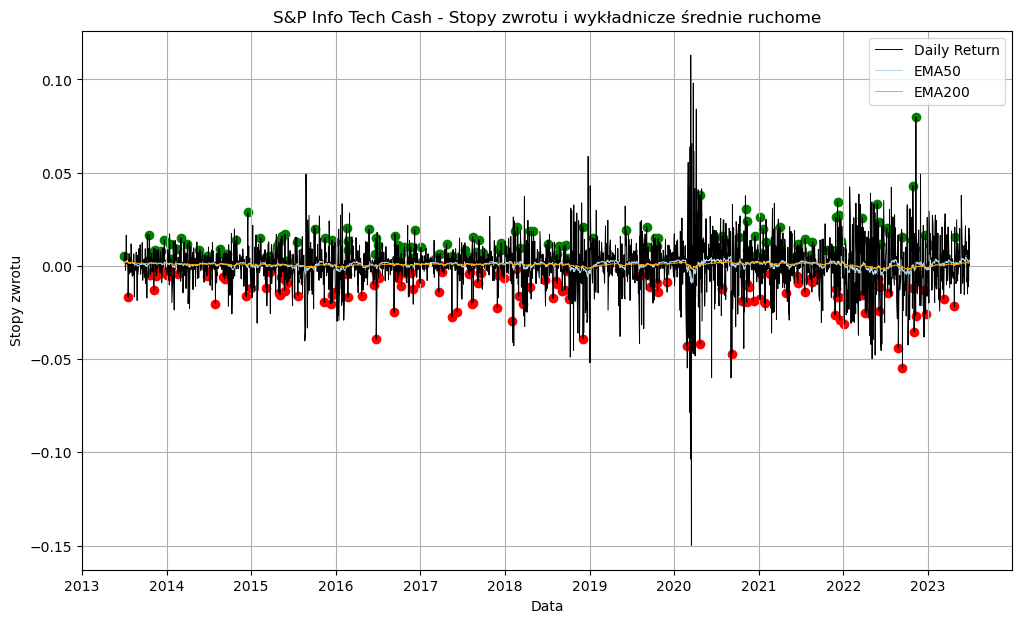

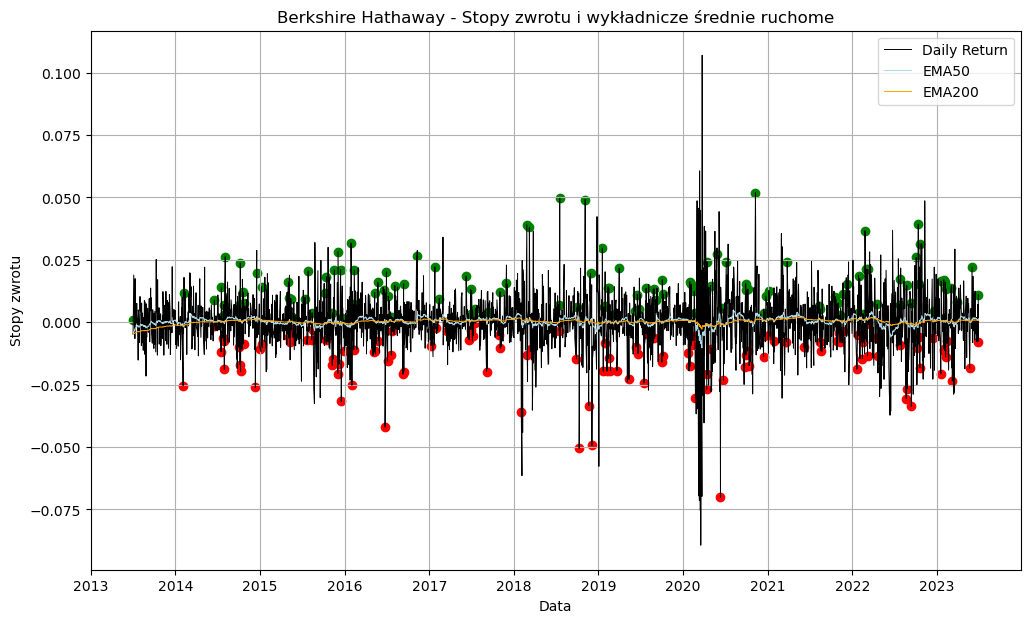

In [19]:
for portfolio in portfolios.values():
    portfolio.ema_cross()

## Koherencja

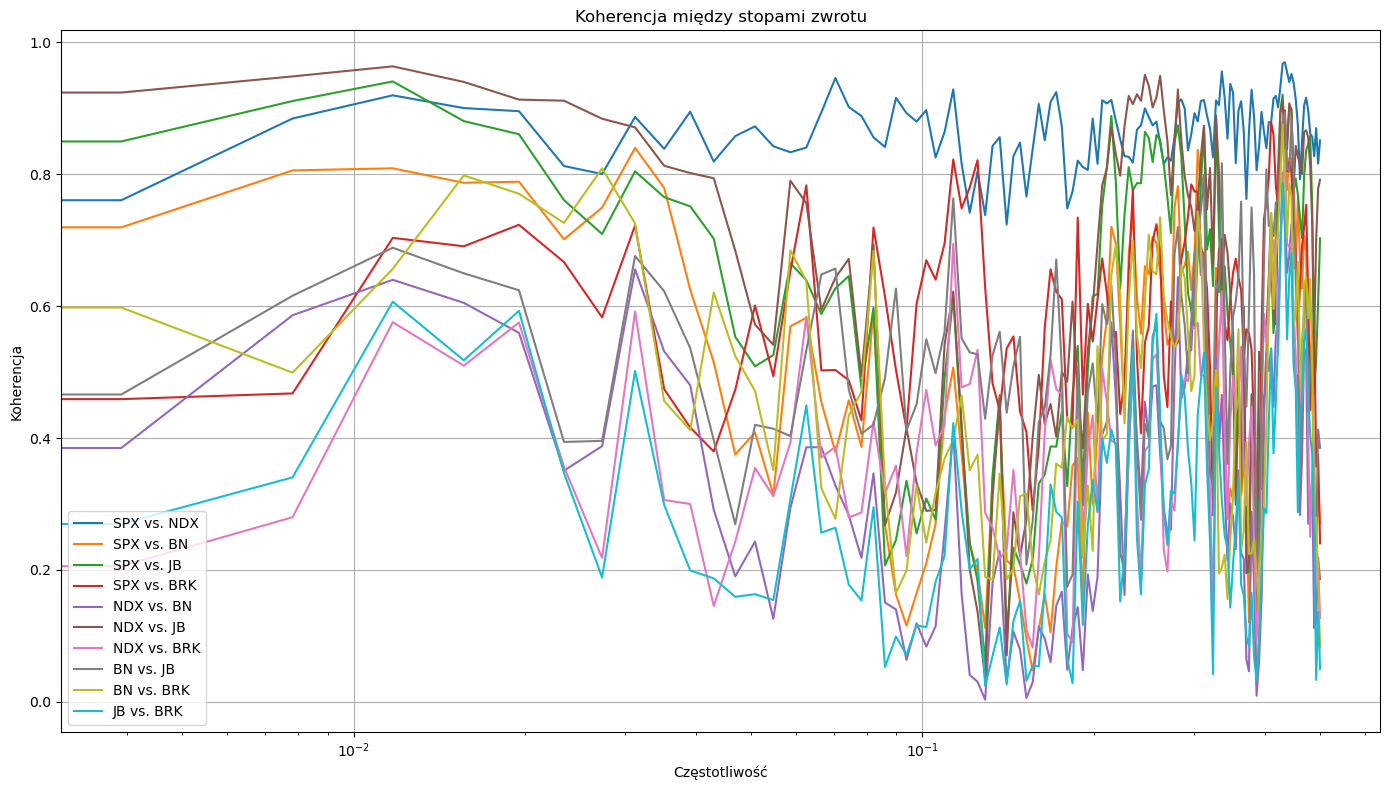

In [20]:
Portfolio.plot_all_coherence(portfolios)

In [23]:
peaks = Portfolio.peak_coherences(portfolios)
print(peaks)

   SPX vs. NDX  SPX vs. BN  SPX vs. JB  SPX vs. BRK  NDX vs. BN  NDX vs. JB  \
0   109.265625  108.281250    2.953125   109.265625  108.281250    2.953125   
1     0.970008    0.882027    0.940848     0.897034    0.802180    0.963714   
2     2.306306    2.327273   85.333333     2.306306    2.327273   85.333333   

   NDX vs. BRK   BN vs. JB  BN vs. BRK  JB vs. BRK  
0   109.265625  109.265625  108.281250  108.281250  
1     0.836919    0.894072    0.875769    0.786529  
2     2.306306    2.306306    2.327273    2.327273  


## Przesunięcie fazowe

In [36]:
phase_shifts = Portfolio.phase_shift_analysis(portfolios, peaks)
print(phase_shifts)

{'SPX vs. NDX': 0.020456369287479254, 'SPX vs. BN': 0.8511223475601705, 'SPX vs. JB': 0.3056291777337277, 'SPX vs. BRK': 0.014285881618633646, 'NDX vs. BN': 0.7999278940507947, 'NDX vs. JB': 0.32501420190623, 'NDX vs. BRK': -0.01779897546816693, 'BN vs. JB': 0.04054710467295579, 'BN vs. BRK': -0.8854785146696864, 'JB vs. BRK': -1.0285012334346018}


## Wzmocnienie

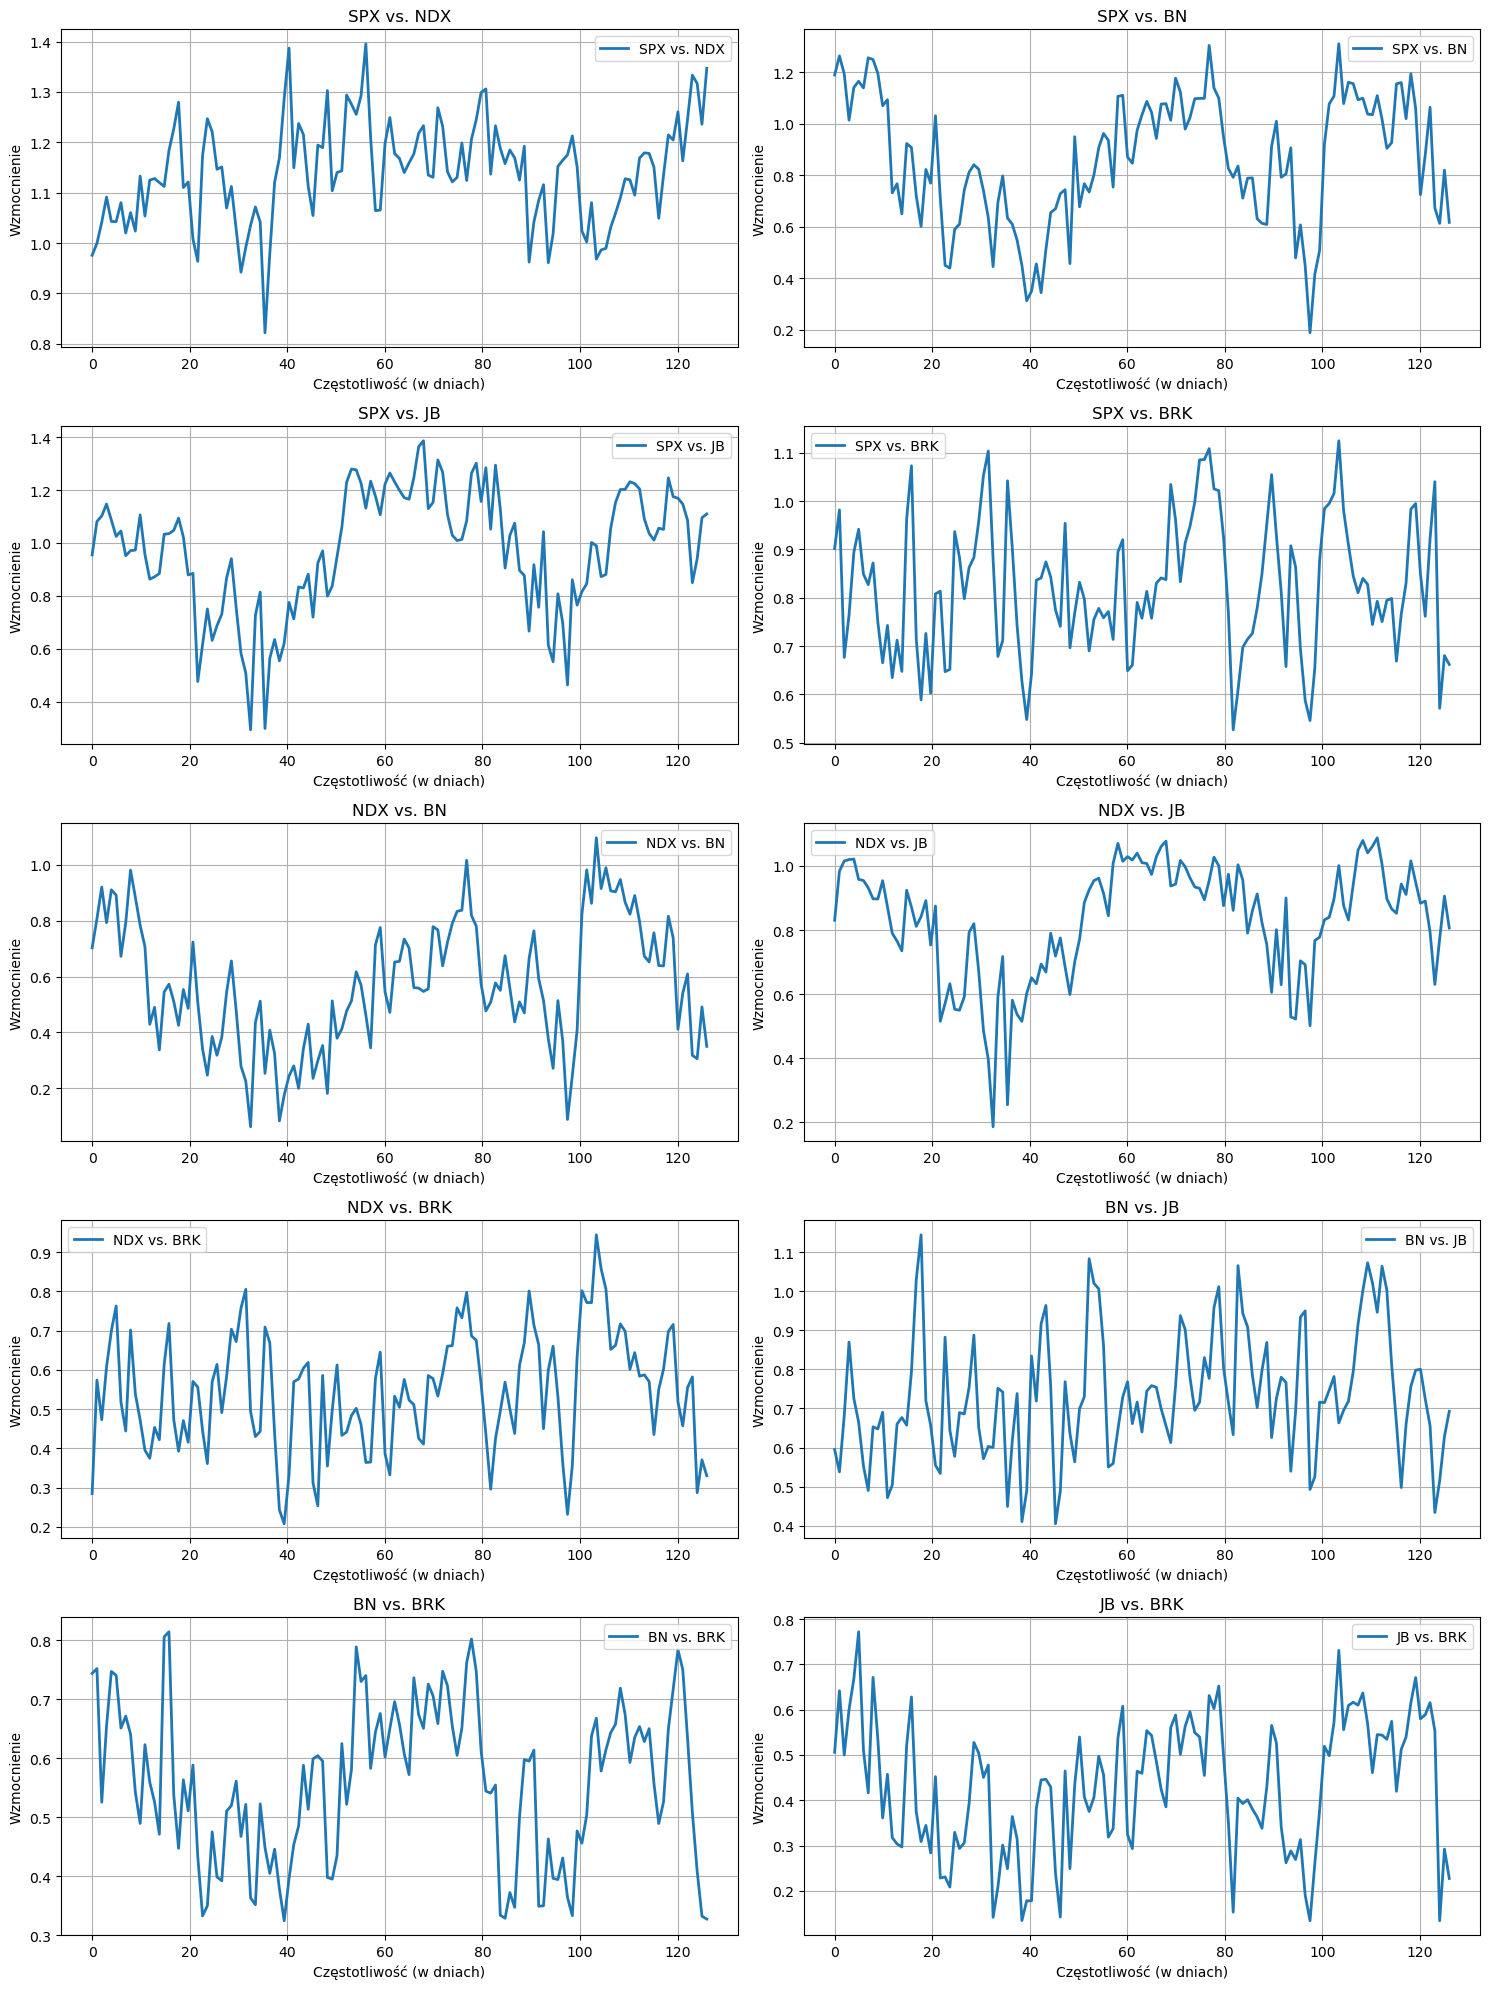

{'SPX vs. NDX': 1.1276559972450368, 'SPX vs. BN': 1.0997151320878846, 'SPX vs. JB': 1.1469241794409768, 'SPX vs. BRK': 0.8275199311914251, 'NDX vs. BN': 0.9469788587679899, 'NDX vs. JB': 1.020104160771862, 'NDX vs. BRK': 0.6981145749059874, 'BN vs. JB': 1.0732519212535656, 'BN vs. BRK': 0.7186813010519384, 'JB vs. BRK': 0.636860939748698}


In [38]:
gains = Portfolio.cross_spectral_gain_analysis(portfolios, peaks)
print(gains)